In this tutorial I’ll explain how to build a simple working 
Recurrent Neural Network in TensorFlow! 

We will build a simple Echo-RNN that remembers the input sequence and then echoes it after a few time-steps. This will help us understand how
memory works 

We are mapping two sequences!

# What is an RNN?
It is short for “Recurrent Neural Network”, and is basically a neural 
network that can be used when your data is treated as a sequence, where 
the particular order of the data-points matter. More importantly, this 
sequence can be of arbitrary length.

The most straight-forward example is perhaps a time-seriedems of numbers, 
where the task is to predict the next value given previous values. The 
input to the RNN at every time-step is the current value as well as a 
state vector which represent what the network has “seen” at time-steps 
before. This state-vector is the encoded memory of the RNN, initially 
set to zero.

Great paper on this 
https://arxiv.org/pdf/1506.00019.pdf

In [1]:
from IPython.display import Image
from IPython.core.display import HTML 
from __future__ import print_function, division
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
Image(url= "https://cdn-images-1.medium.com/max/1600/1*UkI9za9zTR-HL8uM15Wmzw.png")

/home/yingweiy/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
#hyperparams

num_epochs = 100
total_series_length = 50000
truncated_backprop_length = 15
state_size = 4
num_classes = 2
echo_step = 3
batch_size = 5
num_batches = total_series_length//batch_size//truncated_backprop_length
print(num_batches)

666


In [3]:
#Step 1 - Collect data
#Now generate the training data, 
#the input is basically a random binary vector. The output will be the 
#“echo” of the input, shifted echo_step steps to the right.

#Notice the reshaping of the data into a matrix with batch_size rows. 
#Neural networks are trained by approximating the gradient of loss function 
#with respect to the neuron-weights, by looking at only a small subset of the data, 
#also known as a mini-batch.The reshaping takes the whole dataset and puts it into 
#a matrix, that later will be sliced up into these mini-batches.

def generateData():
    #0,1, 50K samples, 50% chance each chosen
    x = np.array(np.random.choice(2, total_series_length, p=[0.5, 0.5]))
    #shift 3 steps to the left
    y = np.roll(x, echo_step)
    #padd beginning 3 values with 0
    y[0:echo_step] = 0
    #Gives a new shape to an array without changing its data.
    #The reshaping takes the whole dataset and puts it into a matrix, 
    #that later will be sliced up into these mini-batches.
    x = x.reshape((batch_size, -1))  # The first index changing slowest, subseries as rows
    y = y.reshape((batch_size, -1))

    return (x, y)

data = generateData()

print(data)

(array([[1, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 1],
       [0, 0, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 1, 0, 1],
       [0, 1, 1, ..., 1, 0, 1]]), array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 1, ..., 0, 0, 0],
       [1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 1, 1]]))


In [10]:
print(data[0][0,0:10])
print(data[1][0,0:10])

[1 0 0 0 1 0 0 0 0 0]
[0 0 0 1 0 0 0 1 0 0]


In [11]:
#Schematic of the reshaped data-matrix, arrow curves shows adjacent time-steps that ended up on different rows. 
#Light-gray rectangle represent a “zero” and dark-gray a “one”.
Image(url= "https://cdn-images-1.medium.com/max/1600/1*aFtwuFsboLV8z5PkEzNLXA.png")

In [12]:
#TensorFlow works by first building up a computational graph, that 
#specifies what operations will be done. The input and output of this graph
#is typically multidimensional arrays, also known as tensors. 
#The graph, or parts of it can then be executed iteratively in a 
#session, this can either be done on the CPU, GPU or even a resource 
#on a remote server.

#operations and tensors

#The two basic TensorFlow data-structures that will be used in this 
#example are placeholders and variables. On each run the batch data 
#is fed to the placeholders, which are “starting nodes” of the 
#computational graph. Also the RNN-state is supplied in a placeholder, 
#which is saved from the output of the previous run.

#Step 2 - Build the Model

#datatype, shape (5, 15) 2D array or matrix, batch size shape for later
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])
batchY_placeholder = tf.placeholder(tf.int32, [batch_size, truncated_backprop_length])

#and one for the RNN state, 5,4 
init_state = tf.placeholder(tf.float32, [batch_size, state_size])

In [13]:
#The weights and biases of the network are declared as TensorFlow variables,
#which makes them persistent across runs and enables them to be updated
#incrementally for each batch.

#3 layer recurrent net, one hidden state

#randomly initialize weights
W = tf.Variable(np.random.rand(state_size+1, state_size), dtype=tf.float32)
#anchor, improves convergance, matrix of 0s 
b = tf.Variable(np.zeros((1,state_size)), dtype=tf.float32)

W2 = tf.Variable(np.random.rand(state_size, num_classes),dtype=tf.float32)
b2 = tf.Variable(np.zeros((1,num_classes)), dtype=tf.float32)

The figure below shows the input data-matrix, and the current batch batchX_placeholder 
is in the dashed rectangle. As we will see later, this “batch window” is slided truncated_backprop_length 
steps to the right at each run, hence the arrow. In our example below batch_size = 3, truncated_backprop_length = 3, 
and total_series_length = 36. Note that these numbers are just for visualization purposes, the values are different in the code. 
The series order index is shown as numbers in a few of the data-points.

In [14]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*n45uYnAfTDrBvG87J-poCA.jpeg")

In [15]:
#Now it’s time to build the part of the graph that resembles the actual RNN computation, 
#first we want to split the batch data into adjacent time-steps.

# Unpack columns  -- axis = 1
#Unpacks the given dimension of a rank-R tensor into rank-(R-1) tensors.
#so a bunch of arrays, 1 batch per time step

inputs_series = tf.unstack(batchX_placeholder, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

As you can see in the picture below that is done by unpacking the columns (axis = 1) of the batch into a Python list. The RNN will simultaneously be training on different parts in the time-series; steps 4 to 6, 16 to 18 and 28 to 30 in the current batch-example. The reason for using the variable names “plural”_”series” is to emphasize that the variable is a list that represent a time-series with multiple entries at each step.

In [16]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*f2iL4zOkBUBGOpVE7kyajg.png")
#Schematic of the current batch split into columns, the order index is shown on each data-point 
#and arrows show adjacent time-steps.

The fact that the training is done on three places simultaneously in our time-series, requires us to save three instances of states when propagating forward. That has already been accounted for, as you see that the init_state placeholder has batch_size rows.


In [18]:
#Forward pass
#state placeholder
current_state = init_state
#series of states through time
states_series = []


#for each set of inputs
#forward pass through the network to get new state value
#store all states in memory
for current_input in inputs_series:
    #format input
    current_input = tf.reshape(current_input, [batch_size, 1])
    #mix both state and input data 
    input_and_state_concatenated = tf.concat([current_input, current_state], 1)  # Increasing number of columns
    #perform matrix multiplication between weights and input, add bias
    #squash with a nonlinearity, for probabiolity value
    next_state = tf.tanh(tf.matmul(input_and_state_concatenated, W) + b)  # Broadcasted addition
    #store the state in memory
    states_series.append(next_state)
    #set current state to next one
    current_state = next_state


Notice the concatenation on line 6, what we actually want to do is calculate the sum of two affine transforms current_input * Wa + current_state * Wb in the figure below. By concatenating those two tensors you will only use one matrix multiplication. The addition of the bias b is broadcasted on all samples in the batch.

In [19]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*fdwNNJ5UOE3Sx0R_Cyfmyg.png")

You may wonder the variable name truncated_backprop_length is supposed to mean. When a RNN is trained, it is actually treated as a deep neural network with reoccurring weights in every layer. These layers will not be unrolled to the beginning of time, that would be too computationally expensive, and are therefore truncated at a limited number of time-steps. In our sample schematics above, the error is backpropagated three steps in our batch

In [21]:
#calculate loss
#second part of forward pass
#logits short for logistic transform
logits_series = [tf.matmul(state, W2) + b2 for state in states_series] #Broadcasted addition
#apply softmax nonlinearity for output probability
predictions_series = [tf.nn.softmax(logits) for logits in logits_series]

#measure loss, calculate softmax again on logits, then compute cross entropy
#measures the difference between two probability distributions
#this will return A Tensor of the same shape as labels and of the same type as logits 
#with the softmax cross entropy loss.
losses = [tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=labels) for logits, labels in zip(logits_series,labels_series)]
#computes average, one value
total_loss = tf.reduce_mean(losses)
#use adagrad to minimize with .3 learning rate
#minimize it with adagrad, not SGD
#One downside of SGD is that it is sensitive to
#the learning rate hyper-parameter. When the data are sparse and features have
#different frequencies, a single learning rate for every weight update can have
#exponential regret.
#Some features can be extremely useful and informative to an optimization problem but 
#they may not show up in most of the training instances or data. If, when they do show up, 
#they are weighted equally in terms of learning rate as a feature that has shown up hundreds 
#of times we are practically saying that the influence of such features means nothing in the 
#overall optimization. it's impact per step in the stochastic gradient descent will be so small 
#that it can practically be discounted). To counter this, AdaGrad makes it such that features 
#that are more sparse in the data have a higher learning rate which translates into a larger 
#update for that feature
#sparse features can be very useful.
#Each feature has a different learning rate which is adaptable. 
#gives voice to the little guy who matters a lot
#weights that receive high gradients will have their effective learning rate reduced, 
#while weights that receive small or infrequent updates will have their effective learning rate increased. 
#great paper http://seed.ucsd.edu/mediawiki/images/6/6a/Adagrad.pdf
train_step = tf.train.AdagradOptimizer(0.3).minimize(total_loss)

The last line is adding the training functionality, TensorFlow will perform back-propagation for us automatically — the computation graph is executed once for each mini-batch and the network-weights are updated incrementally.

Notice the API call to sparse_softmax_cross_entropy_with_logits, it automatically calculates the softmax internally and then computes the cross-entropy. In our example the classes are mutually exclusive (they are either zero or one), which is the reason for using the “Sparse-softmax”, you can read more about it in the API. The usage is to havelogits is of shape [batch_size, num_classes] and labels of shape [batch_size].

In [22]:
#visualizer
def plot(loss_list, predictions_series, batchX, batchY):
    plt.subplot(2, 3, 1)
    plt.cla()
    plt.plot(loss_list)

    for batch_series_idx in range(5):
        one_hot_output_series = np.array(predictions_series)[:, batch_series_idx, :]
        single_output_series = np.array([(1 if out[0] < 0.5 else 0) for out in one_hot_output_series])

        plt.subplot(2, 3, batch_series_idx + 2)
        plt.cla()
        plt.axis([0, truncated_backprop_length, 0, 2])
        left_offset = range(truncated_backprop_length)
        plt.bar(left_offset, batchX[batch_series_idx, :], width=1, color="blue")
        plt.bar(left_offset, batchY[batch_series_idx, :] * 0.5, width=1, color="red")
        plt.bar(left_offset, single_output_series * 0.3, width=1, color="green")

    plt.draw()
    plt.pause(0.0001)

There is a visualization function so we can se what’s going on in the network as we train. It will plot the loss over the time, show training input, training output and the current predictions by the network on different sample series in a training batch.

Instructions for updating:
Use `tf.global_variables_initializer` instead.


<Figure size 432x288 with 0 Axes>

New data, epoch 0
Step 0 Loss 0.87638974


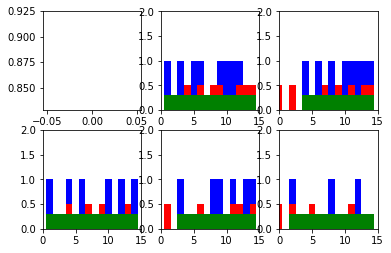

Step 100 Loss 0.6872697


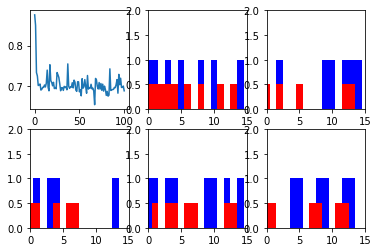

Step 200 Loss 0.49158296


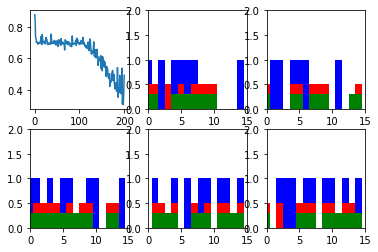

Step 300 Loss 0.023947591


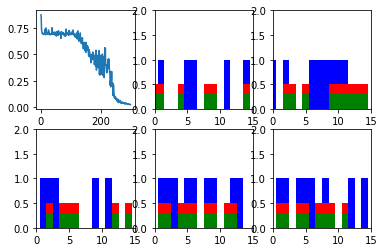

Step 400 Loss 0.011377477


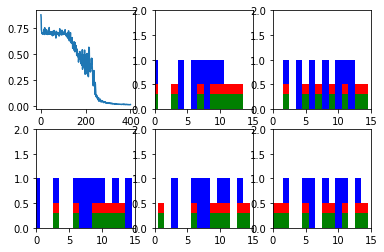

Step 500 Loss 0.0075599924


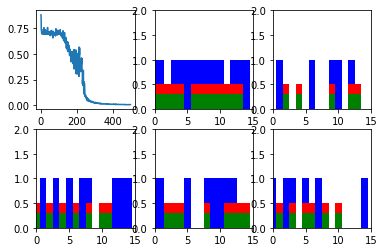

Step 600 Loss 0.004552068


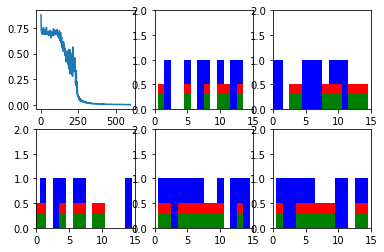

New data, epoch 1
Step 0 Loss 0.34751558


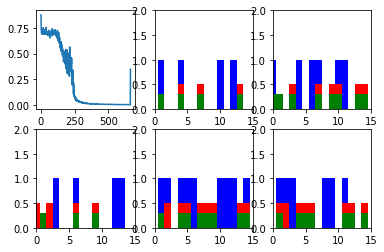

Step 100 Loss 0.0035944604


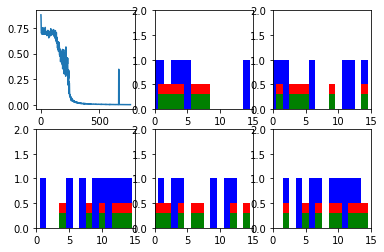

Step 200 Loss 0.0024927862


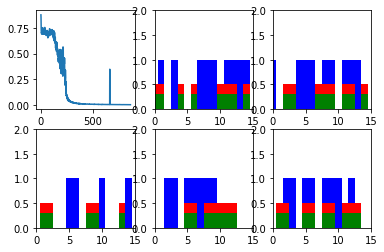

Step 300 Loss 0.0022220942


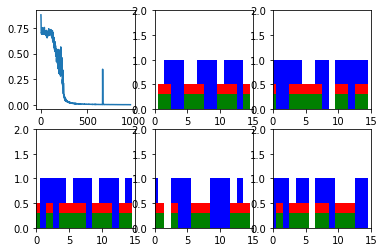

Step 400 Loss 0.002336829


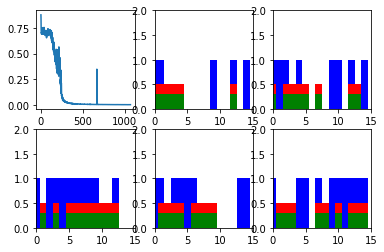

Step 500 Loss 0.0018717677


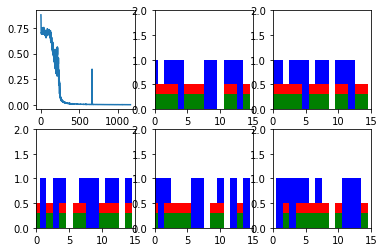

Step 600 Loss 0.0015561387


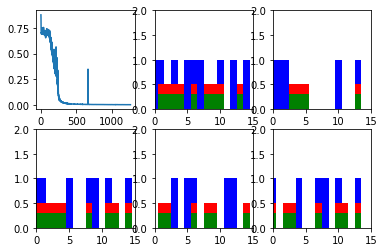

New data, epoch 2
Step 0 Loss 0.2788776


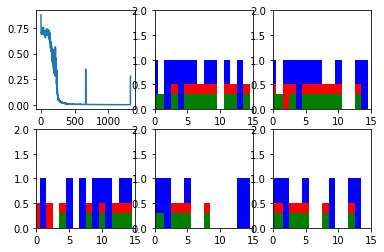

Step 100 Loss 0.0016137403


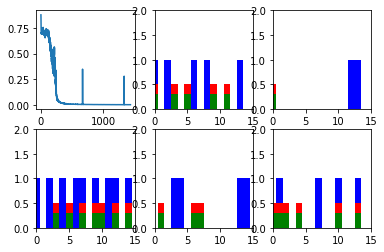

Step 200 Loss 0.0012659441


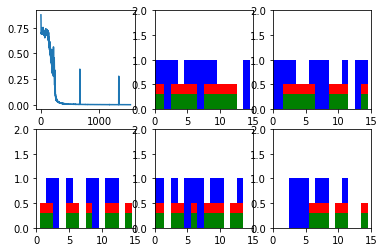

Step 300 Loss 0.0012612523


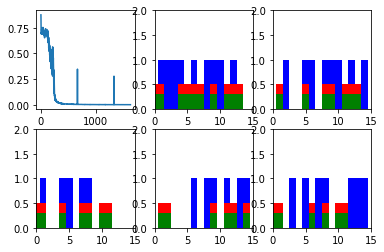

Step 400 Loss 0.0011320708


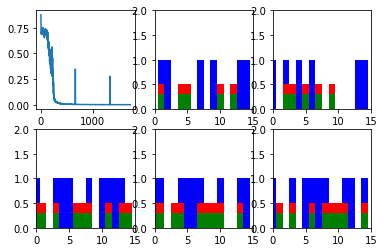

Step 500 Loss 0.0012038529


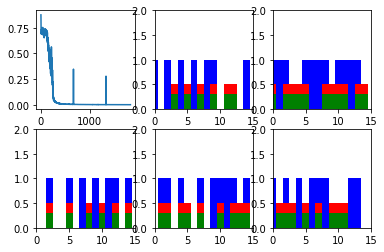

Step 600 Loss 0.0012640144


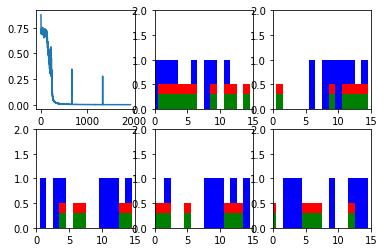

New data, epoch 3
Step 0 Loss 0.15210034


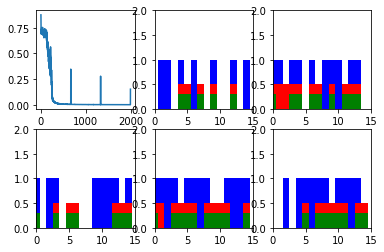

Step 100 Loss 0.0010338183


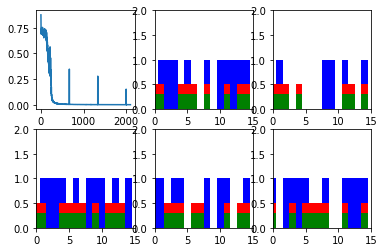

Step 200 Loss 0.00092143874


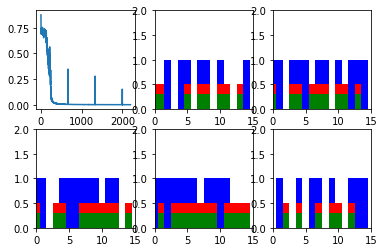

Step 300 Loss 0.00080118055


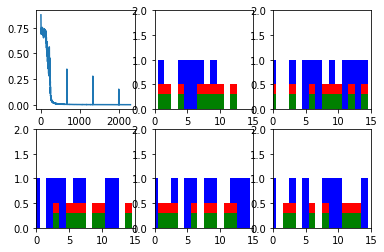

Step 400 Loss 0.0007188247


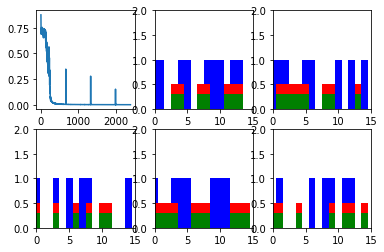

Step 500 Loss 0.00078757334


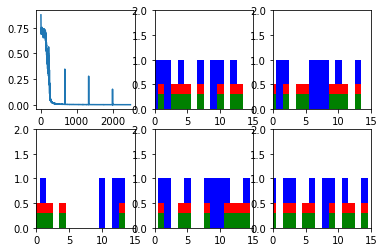

Step 600 Loss 0.00077627104


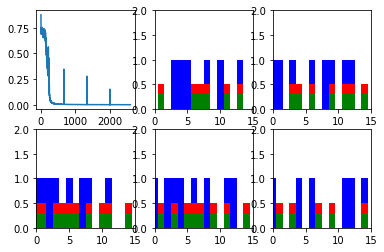

New data, epoch 4
Step 0 Loss 0.2893928


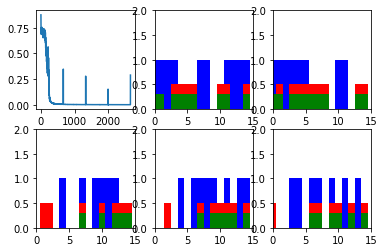

Step 100 Loss 0.0008521053


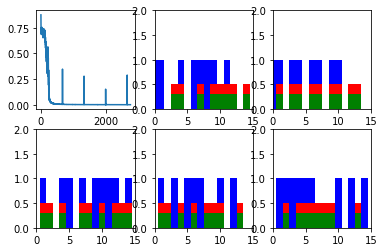

Step 200 Loss 0.0007271555


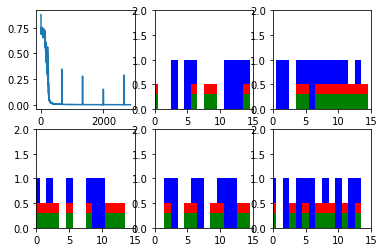

Step 300 Loss 0.0007815161


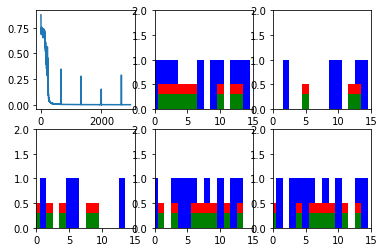

Step 400 Loss 0.0006102956


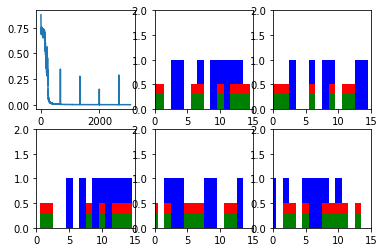

Step 500 Loss 0.000591305


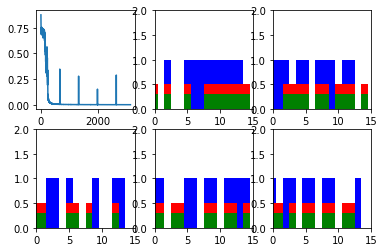

Step 600 Loss 0.0006639035


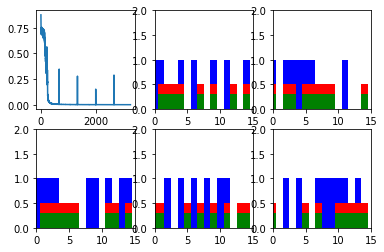

New data, epoch 5
Step 0 Loss 0.13973406


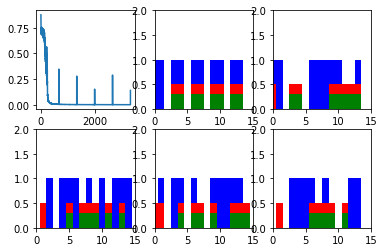

Step 100 Loss 0.0005175347


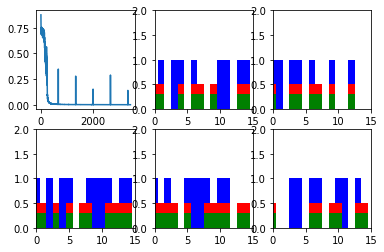

Step 200 Loss 0.0005302283


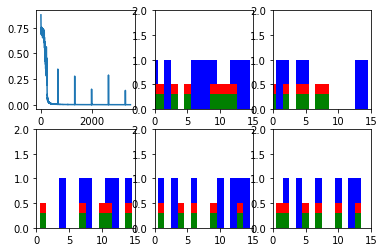

Step 300 Loss 0.00056484685


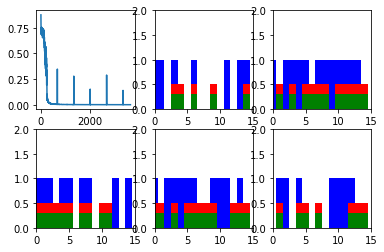

Step 400 Loss 0.0005306486


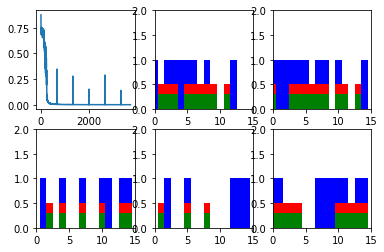

Step 500 Loss 0.00044359345


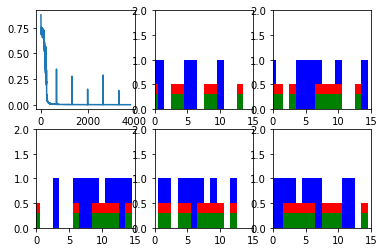

Step 600 Loss 0.00046390732


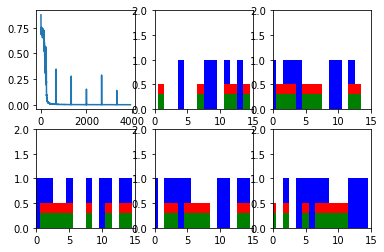

New data, epoch 6
Step 0 Loss 0.3098505


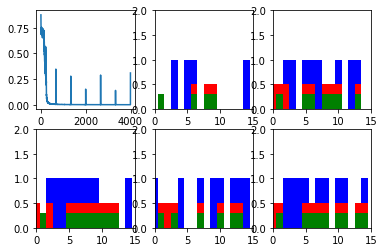

Step 100 Loss 0.0004468578


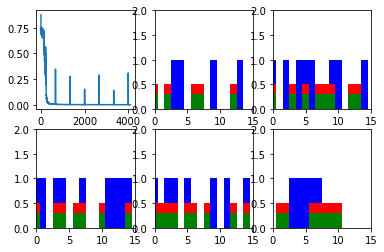

Step 200 Loss 0.00043704043


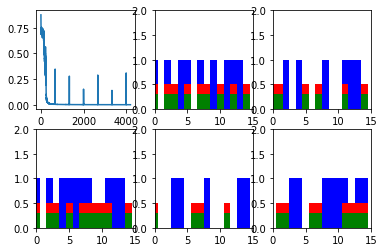

Step 300 Loss 0.000433836


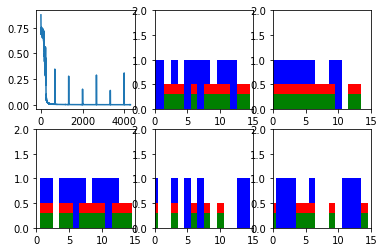

Step 400 Loss 0.00047814805


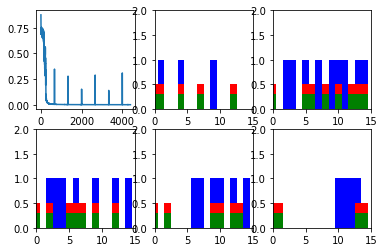

Step 500 Loss 0.00037960726


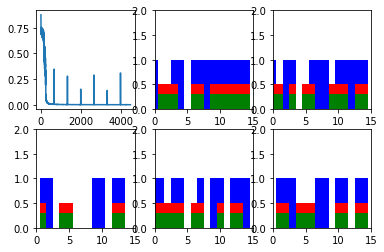

Step 600 Loss 0.00039642534


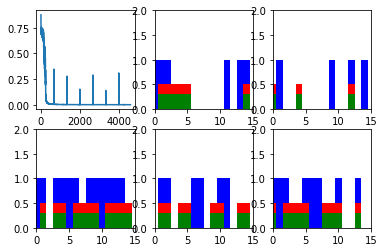

New data, epoch 7
Step 0 Loss 0.22392479


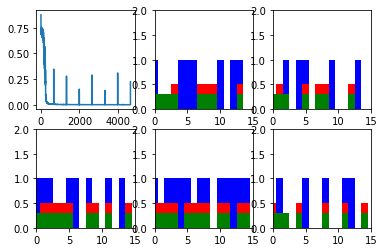

Step 100 Loss 0.00044154332


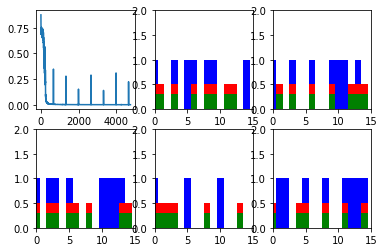

Step 200 Loss 0.0004448095


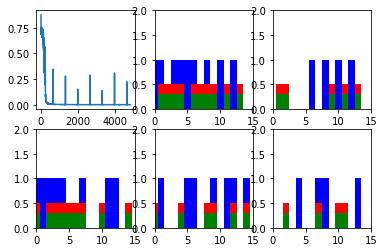

Step 300 Loss 0.00041814626


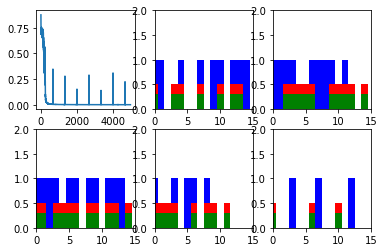

Step 400 Loss 0.00043908204


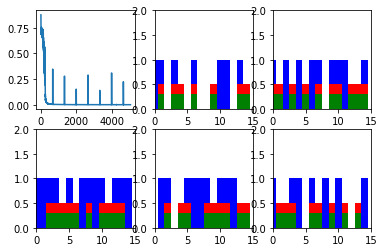

Step 500 Loss 0.00039763693


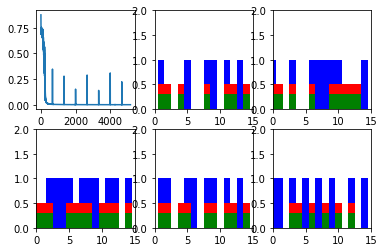

Step 600 Loss 0.00036112627


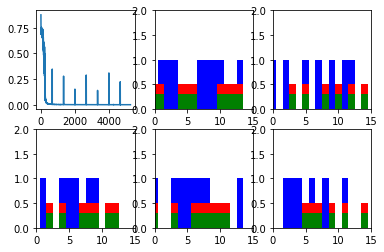

New data, epoch 8
Step 0 Loss 0.31212318


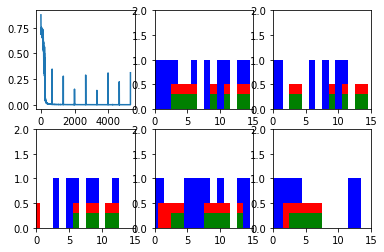

Step 100 Loss 0.00030962765


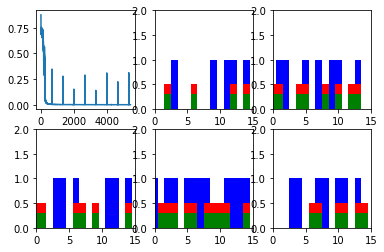

Step 200 Loss 0.00033315067


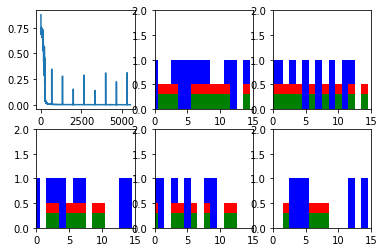

Step 300 Loss 0.00031060178


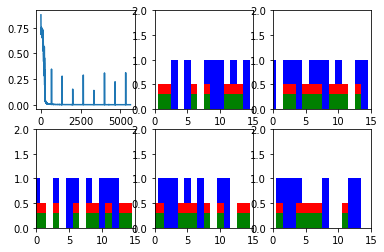

Step 400 Loss 0.00033341176


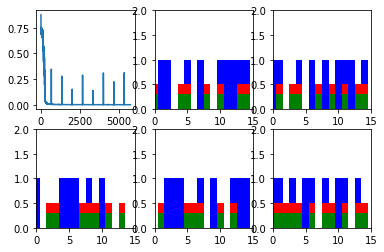

Step 500 Loss 0.0002871323


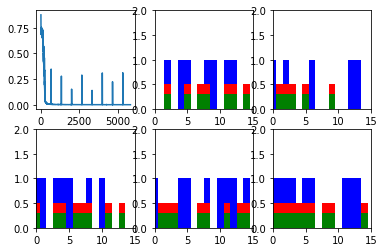

Step 600 Loss 0.00032369877


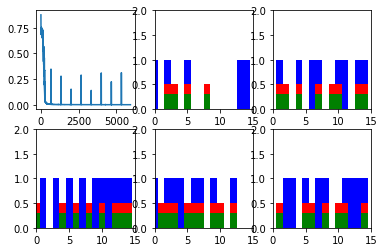

New data, epoch 9
Step 0 Loss 0.45155206


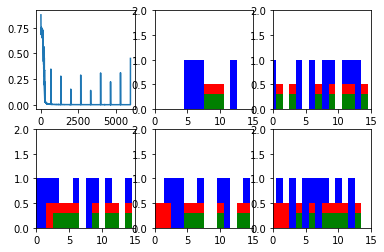

Step 100 Loss 0.00031611964


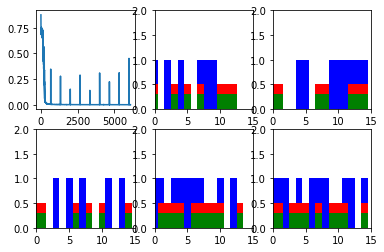

Step 200 Loss 0.00030961557


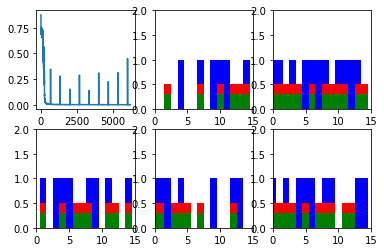

Step 300 Loss 0.00032024688


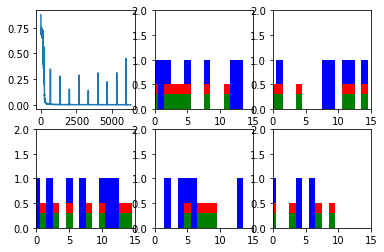

Step 400 Loss 0.0002686887


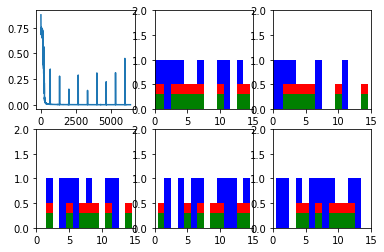

Step 500 Loss 0.00026056092


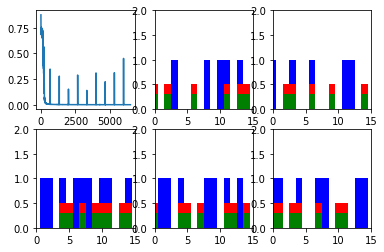

Step 600 Loss 0.00026718472


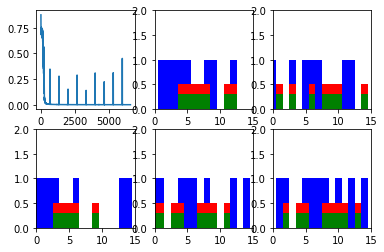

New data, epoch 10
Step 0 Loss 0.4029449


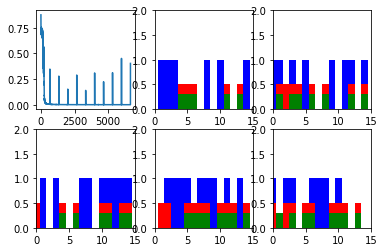

Step 100 Loss 0.00028510744


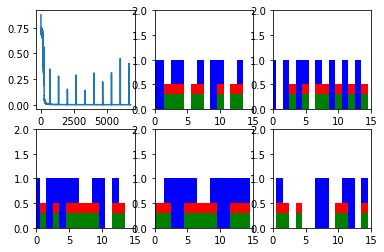

Step 200 Loss 0.00027797697


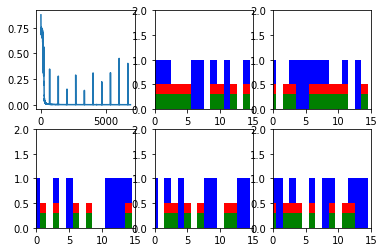

Step 300 Loss 0.0002752443


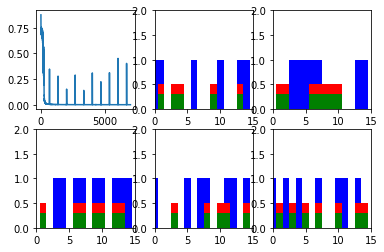

Step 400 Loss 0.0003714818


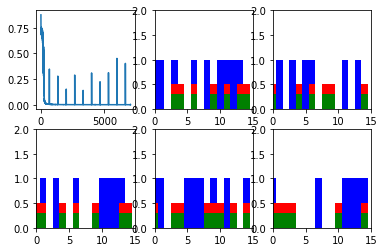

Step 500 Loss 0.0003626681


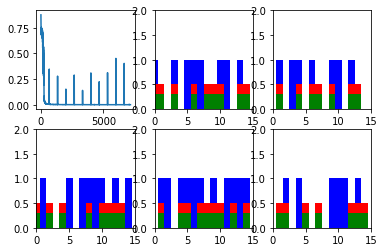

Step 600 Loss 0.0002906286


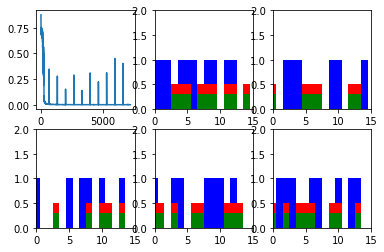

New data, epoch 11
Step 0 Loss 0.29500404


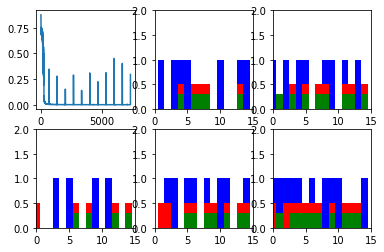

Step 100 Loss 0.0003269087


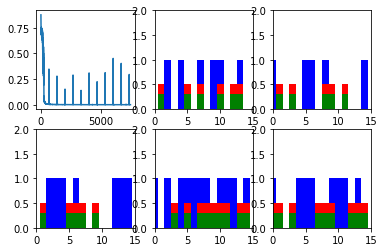

Step 200 Loss 0.00029314894


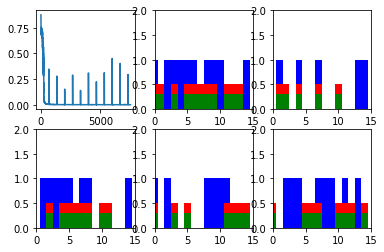

Step 300 Loss 0.00031564131


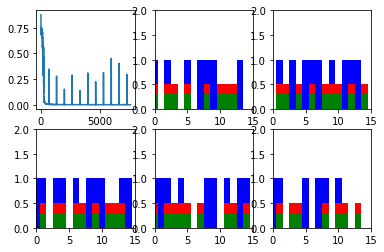

Step 400 Loss 0.00029430792


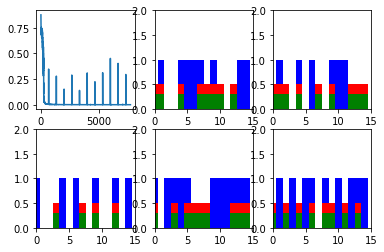

Step 500 Loss 0.00027831338


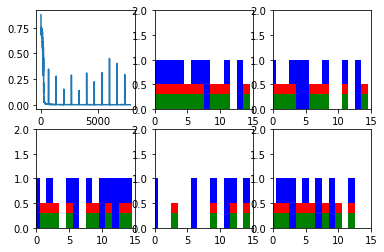

Step 600 Loss 0.0002520289


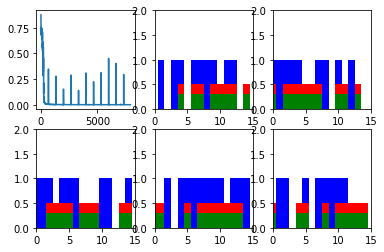

New data, epoch 12
Step 0 Loss 0.39049193


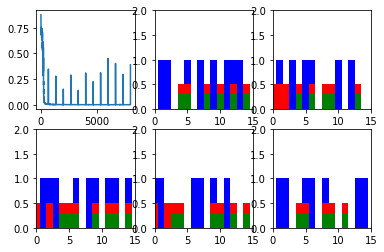

Step 100 Loss 0.00024146376


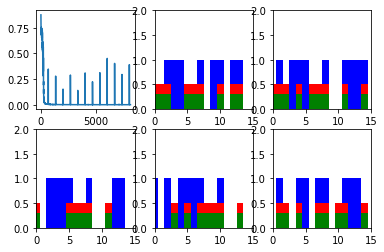

Step 200 Loss 0.0002579089


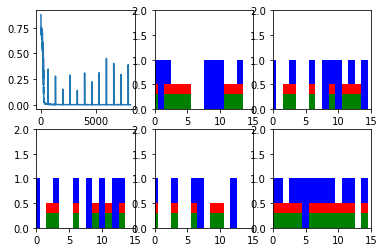

Step 300 Loss 0.0002564912


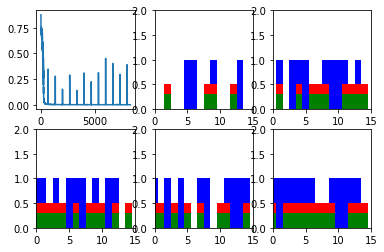

Step 400 Loss 0.00022838401


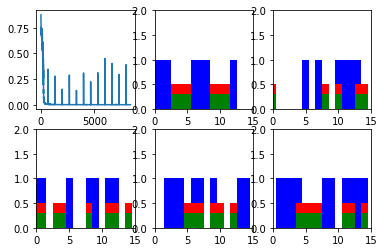

Step 500 Loss 0.00023414486


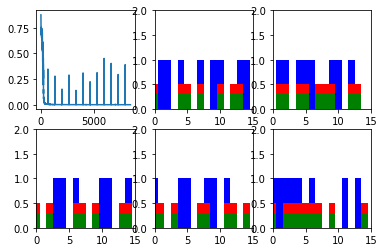

Step 600 Loss 0.00025093614


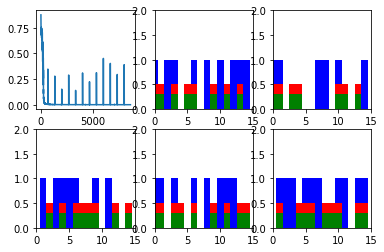

New data, epoch 13
Step 0 Loss 0.35187966


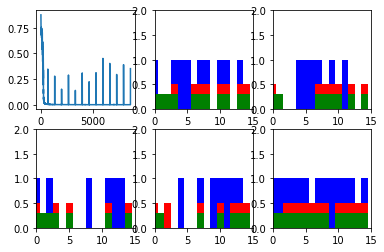

Step 100 Loss 0.00023791047


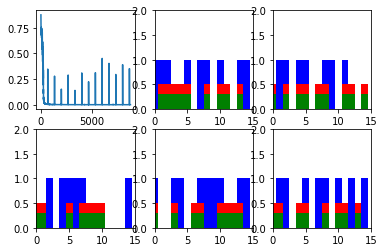

Step 200 Loss 0.0002839696


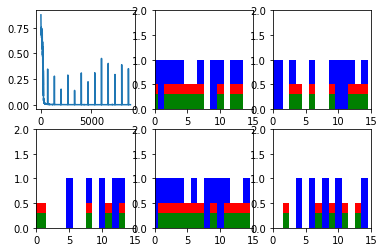

Step 300 Loss 0.00028214554


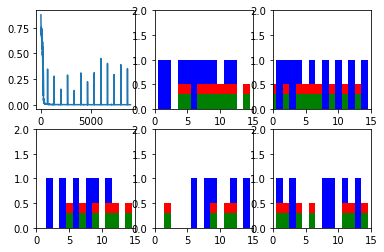

Step 400 Loss 0.00022715815


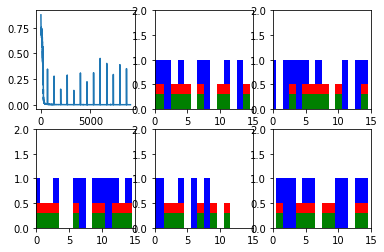

Step 500 Loss 0.00024270713


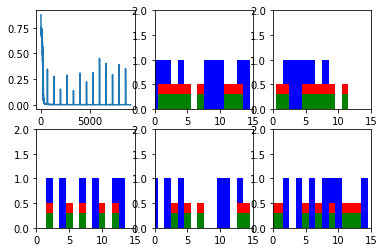

Step 600 Loss 0.00023314975


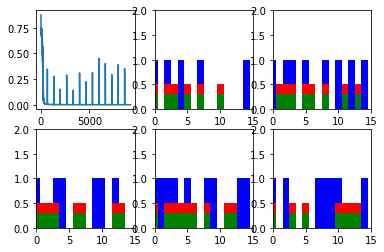

New data, epoch 14
Step 0 Loss 0.1397535


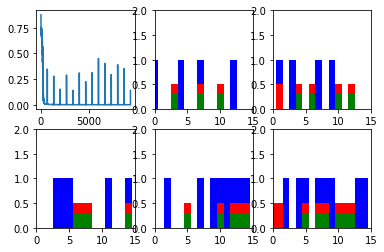

Step 100 Loss 0.00020530689


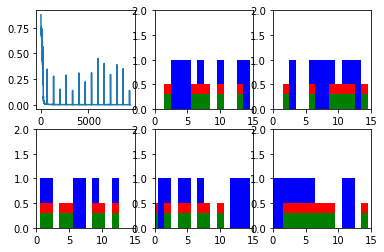

Step 200 Loss 0.00019585523


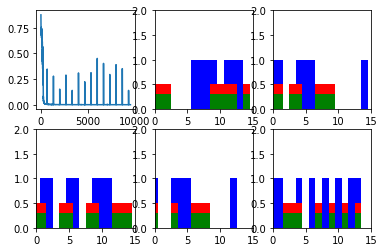

Step 300 Loss 0.00024368575


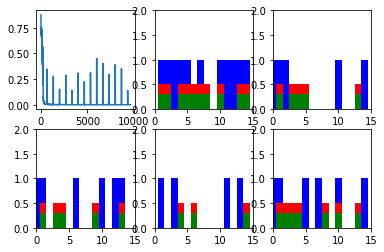

Step 400 Loss 0.0002204961


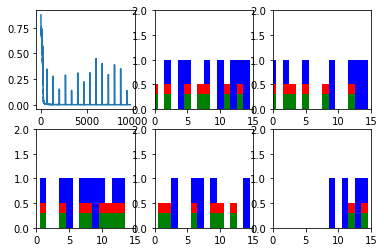

Step 500 Loss 0.00019619334


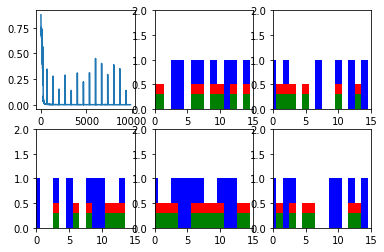

Step 600 Loss 0.00020326037


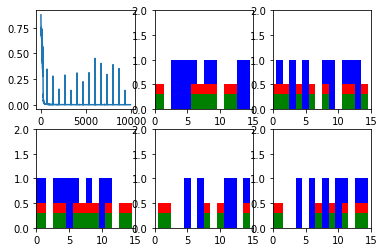

New data, epoch 15
Step 0 Loss 0.096025616


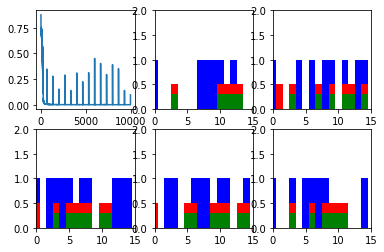

Step 100 Loss 0.00020040778


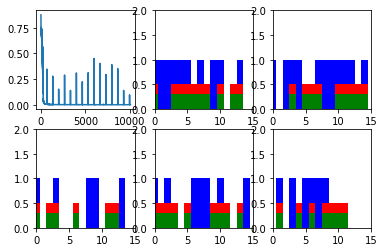

Step 200 Loss 0.00017687102


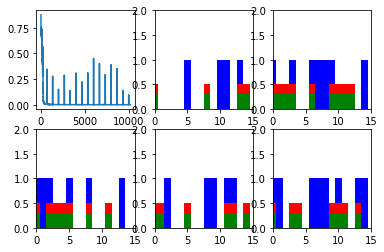

Step 300 Loss 0.00020391958


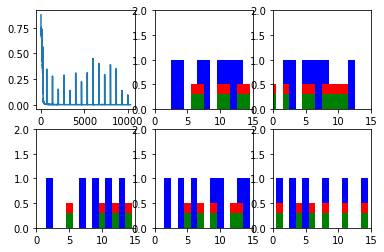

Step 400 Loss 0.00020037511


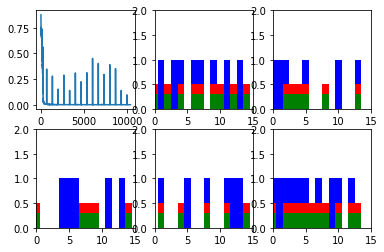

Step 500 Loss 0.00019015685


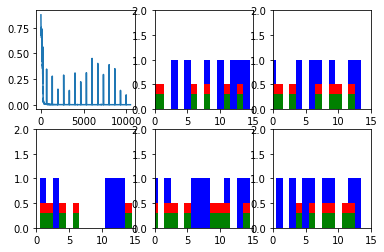

Step 600 Loss 0.00013898821


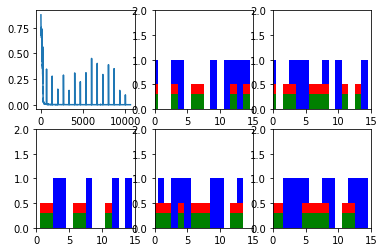

New data, epoch 16
Step 0 Loss 0.24688509


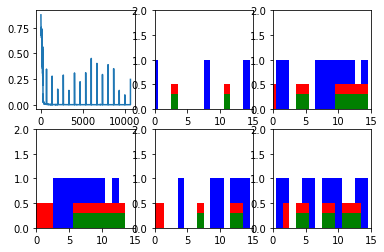

Step 100 Loss 0.00015443242


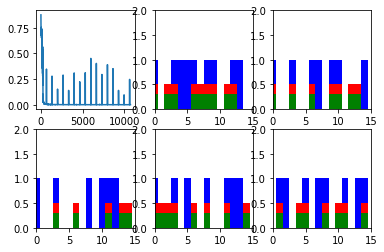

Step 200 Loss 0.00017636002


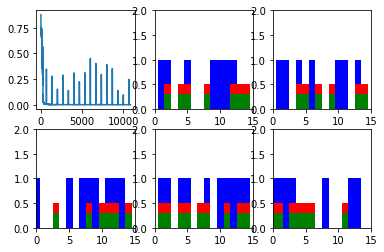

Step 300 Loss 0.00019076579


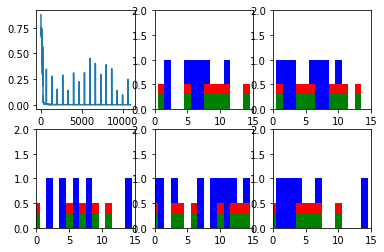

Step 400 Loss 0.00015995039


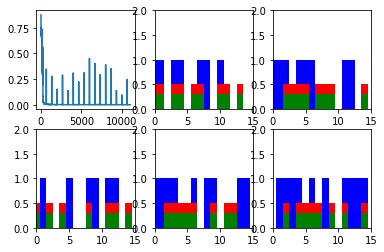

Step 500 Loss 0.00018827789


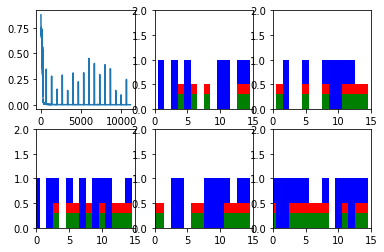

Step 600 Loss 0.00015847798


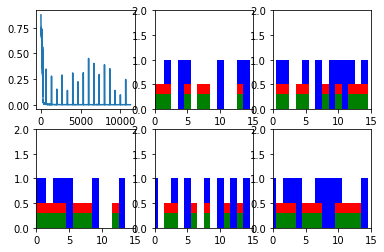

New data, epoch 17
Step 0 Loss 0.32439733


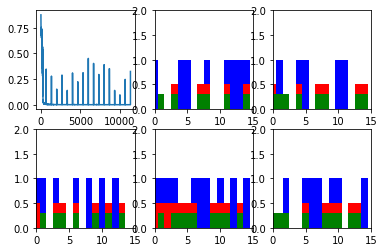

Step 100 Loss 0.00019300163


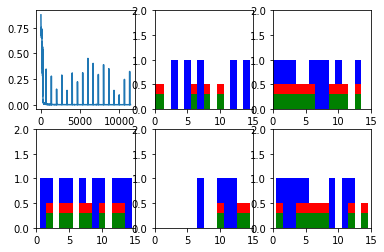

Step 200 Loss 0.00019503216


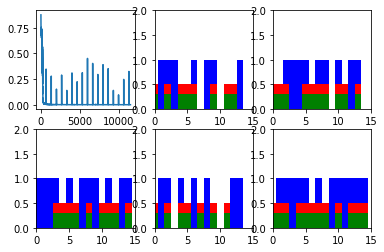

Step 300 Loss 0.00018339837


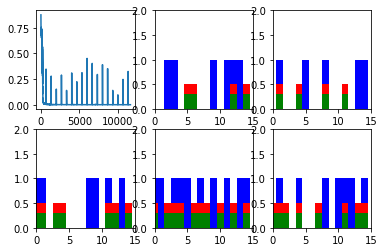

Step 400 Loss 0.00014194816


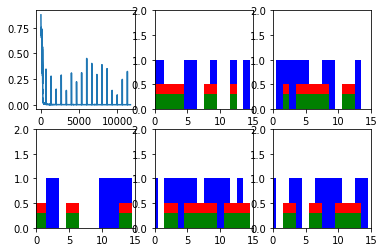

Step 500 Loss 0.00016762702


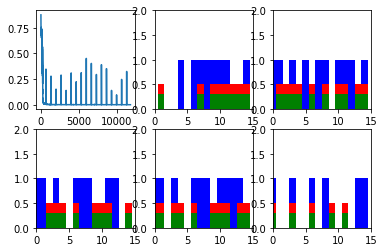

Step 600 Loss 0.0001775062


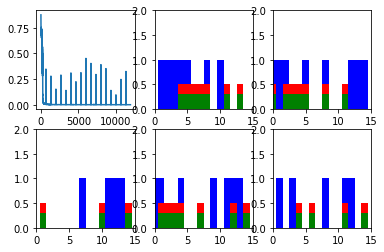

New data, epoch 18
Step 0 Loss 0.23237231


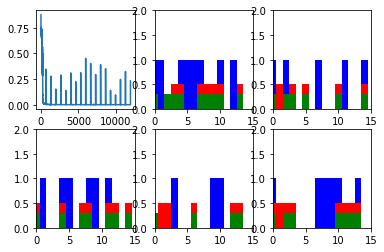

Step 100 Loss 0.0001603174


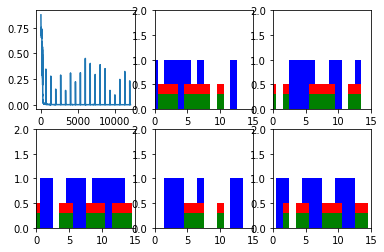

Step 200 Loss 0.00016287743


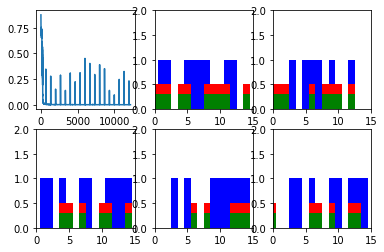

Step 300 Loss 0.00017515341


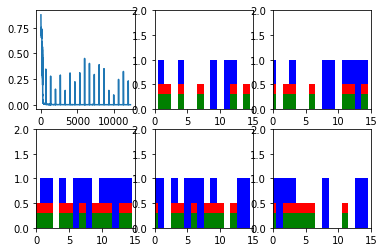

Step 400 Loss 0.00018809778


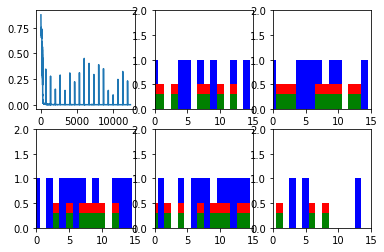

Step 500 Loss 0.00016028062


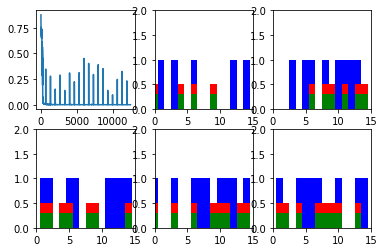

Step 600 Loss 0.00016549468


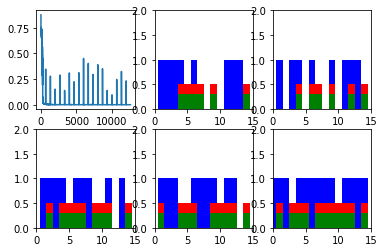

New data, epoch 19
Step 0 Loss 0.35249865


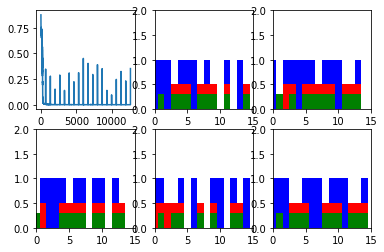

Step 100 Loss 0.00017096869


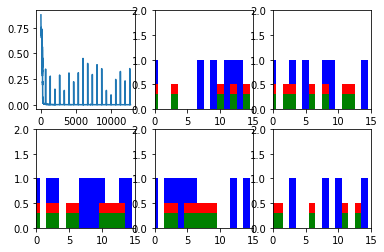

Step 200 Loss 0.00013860395


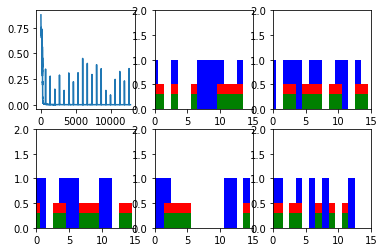

Step 300 Loss 0.00016596248


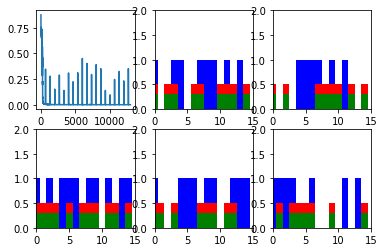

Step 400 Loss 0.00015394285


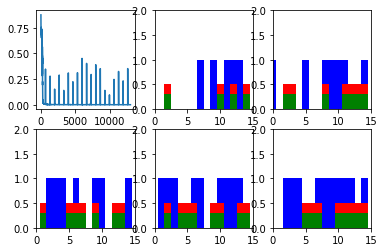

Step 500 Loss 0.00014652291


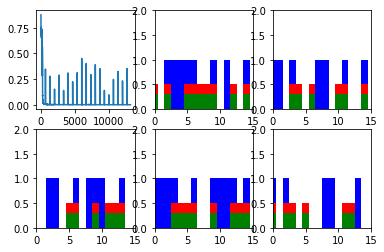

Step 600 Loss 0.00015516733


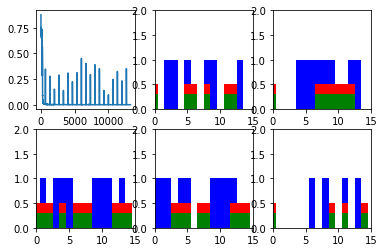

New data, epoch 20
Step 0 Loss 0.28599668


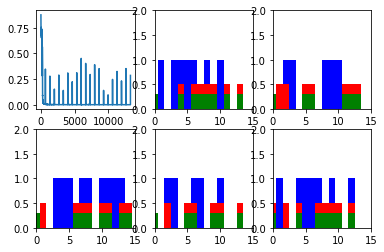

Step 100 Loss 0.00015678153


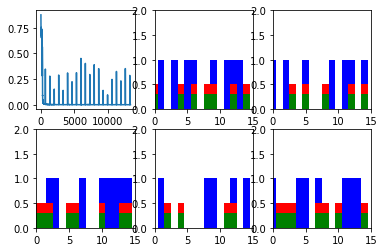

Step 200 Loss 0.00014371447


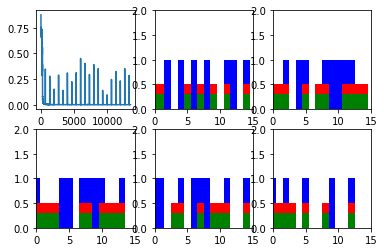

Step 300 Loss 0.00018663962


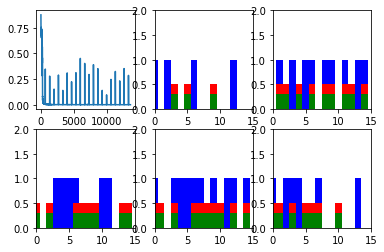

Step 400 Loss 0.00014438451


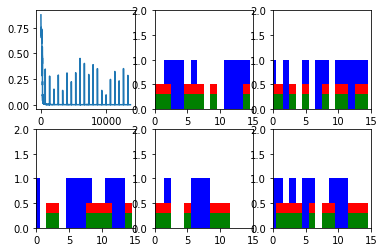

Step 500 Loss 0.00016188687


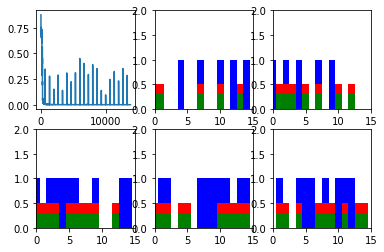

Step 600 Loss 0.0001369185


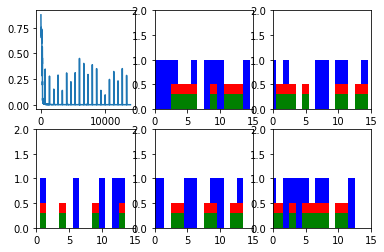

New data, epoch 21
Step 0 Loss 0.23604347


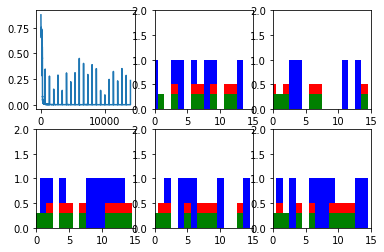

Step 100 Loss 0.00014057146


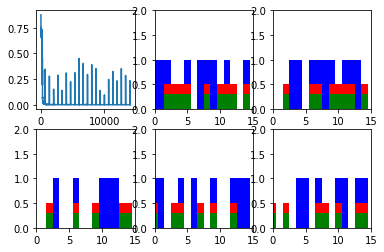

Step 200 Loss 0.00014117252


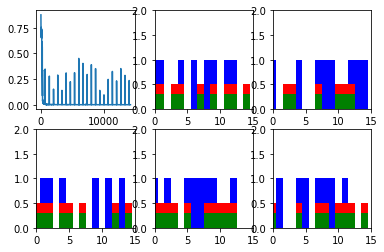

Step 300 Loss 0.00013003909


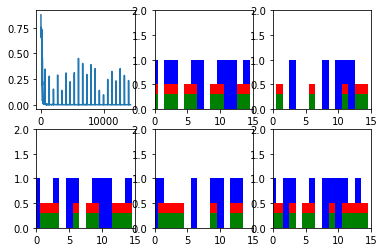

Step 400 Loss 0.0001460383


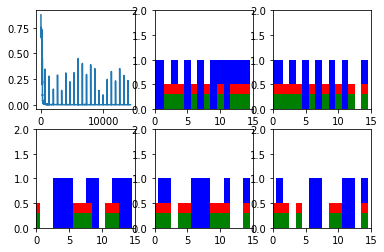

Step 500 Loss 0.00016535194


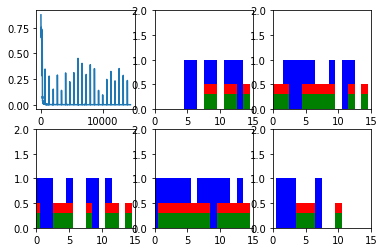

Step 600 Loss 0.00011070556


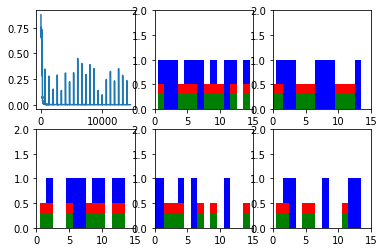

New data, epoch 22
Step 0 Loss 0.32407677


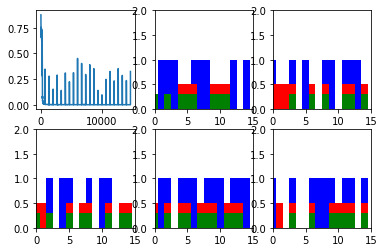

Step 100 Loss 0.00012391664


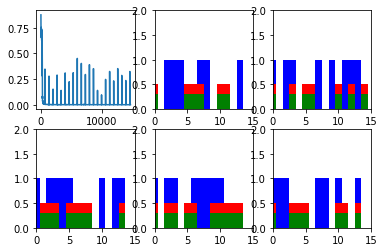

Step 200 Loss 0.00012825665


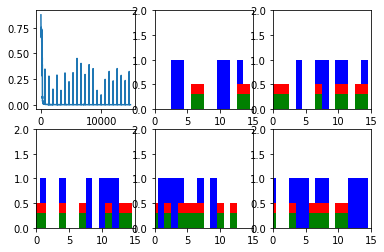

Step 300 Loss 0.0001647036


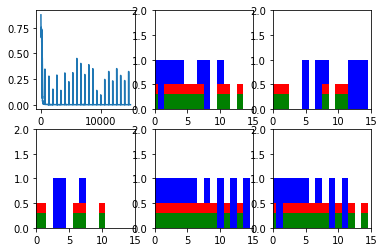

Step 400 Loss 0.00013047583


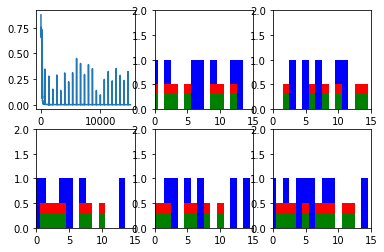

Step 500 Loss 0.00013794383


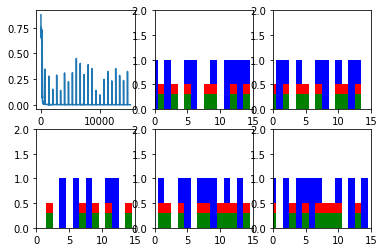

Step 600 Loss 0.00013521811


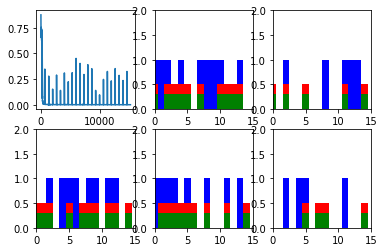

New data, epoch 23
Step 0 Loss 0.23161374


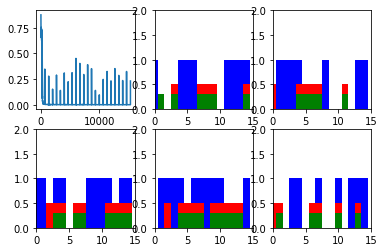

Step 100 Loss 0.0001379806


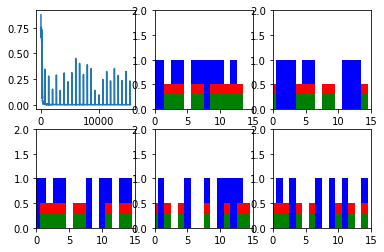

Step 200 Loss 0.00012163922


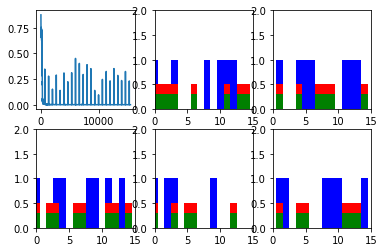

Step 300 Loss 0.00014515899


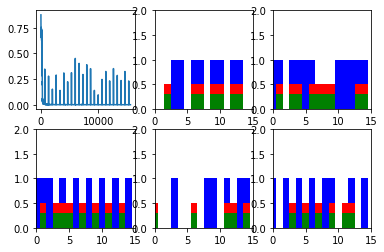

Step 400 Loss 0.00014215159


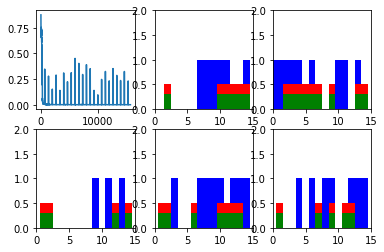

Step 500 Loss 0.00012137491


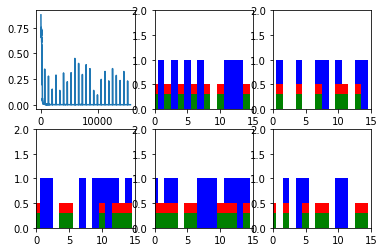

Step 600 Loss 0.00011424847


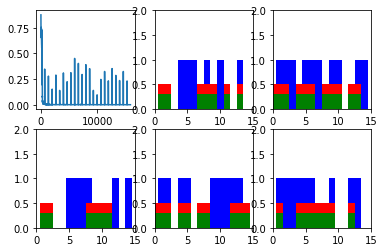

New data, epoch 24
Step 0 Loss 0.39174327


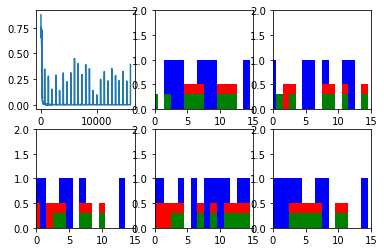

Step 100 Loss 0.00019309866


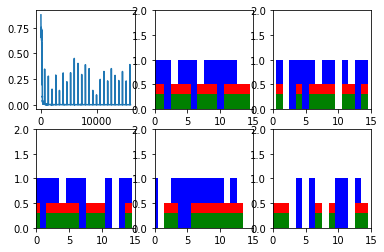

Step 200 Loss 0.00019405635


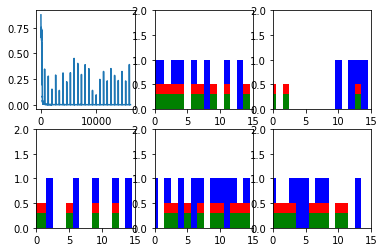

Step 300 Loss 0.00019486665


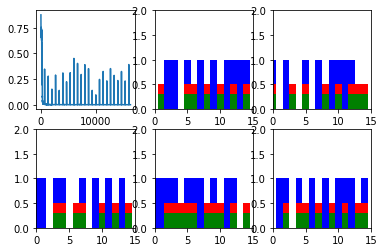

Step 400 Loss 0.00014849415


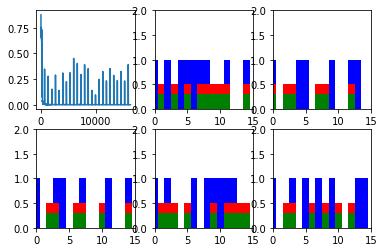

Step 500 Loss 0.00015354632


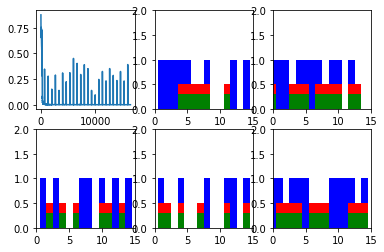

Step 600 Loss 0.00016957146


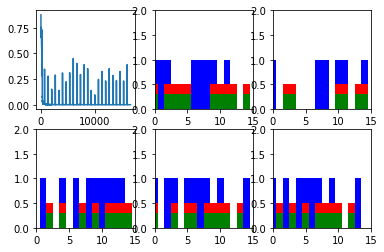

New data, epoch 25
Step 0 Loss 0.14189129


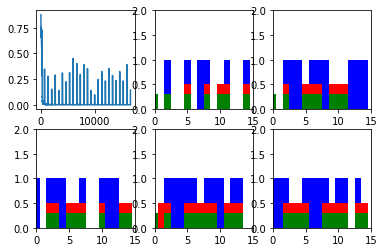

Step 100 Loss 0.00016033824


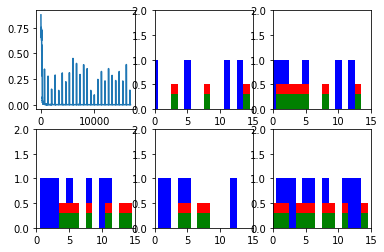

Step 200 Loss 0.00015640185


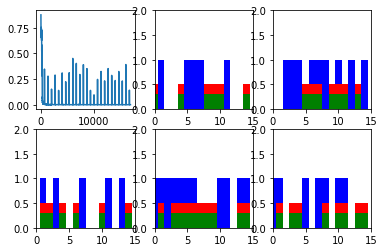

Step 300 Loss 0.00013102812


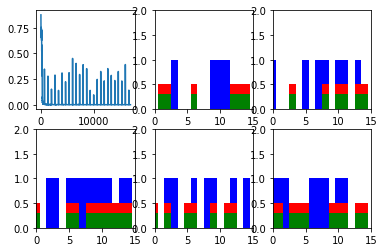

Step 400 Loss 0.00013263877


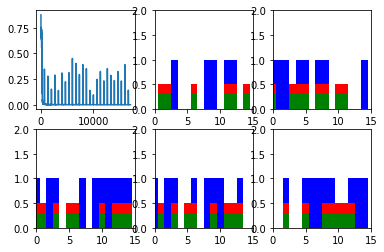

Step 500 Loss 0.00013281523


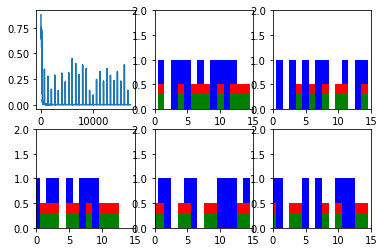

Step 600 Loss 0.00015233022


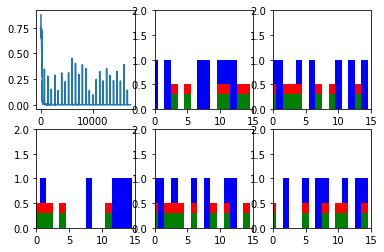

New data, epoch 26
Step 0 Loss 0.19650862


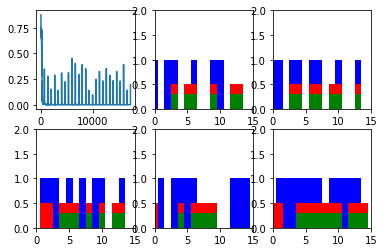

Step 100 Loss 0.00013585621


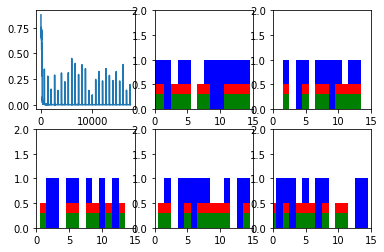

Step 200 Loss 0.00013526059


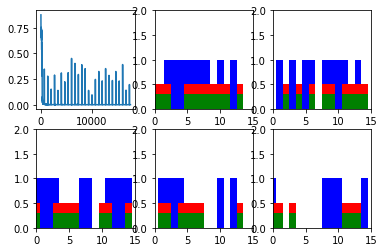

Step 300 Loss 0.00013413529


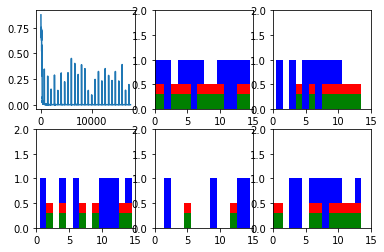

Step 400 Loss 0.000112572634


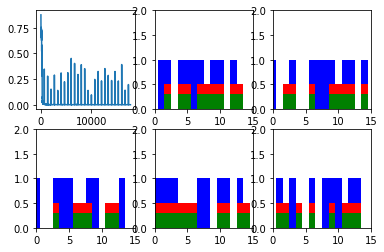

Step 500 Loss 0.0001230003


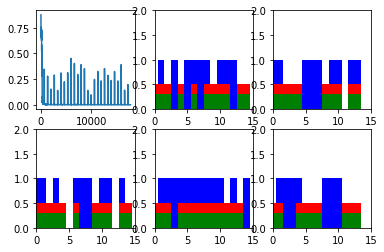

Step 600 Loss 0.000129711


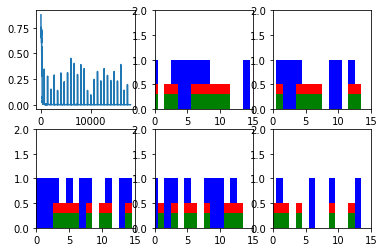

New data, epoch 27
Step 0 Loss 0.2787266


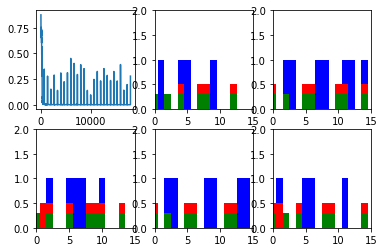

Step 100 Loss 0.00016478777


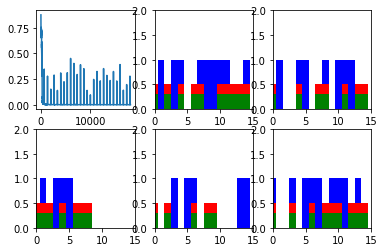

Step 200 Loss 0.00016243916


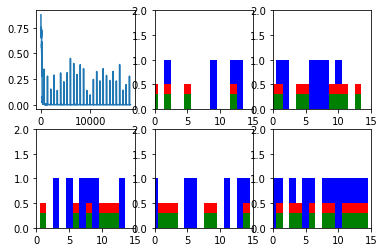

Step 300 Loss 0.00013535227


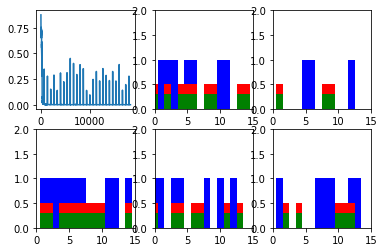

Step 400 Loss 0.00014108096


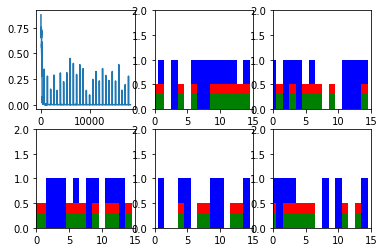

Step 500 Loss 0.00013334317


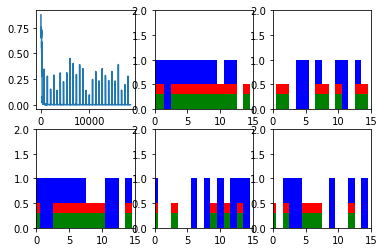

Step 600 Loss 0.00011866845


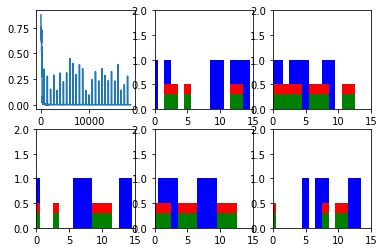

New data, epoch 28
Step 0 Loss 0.14484252


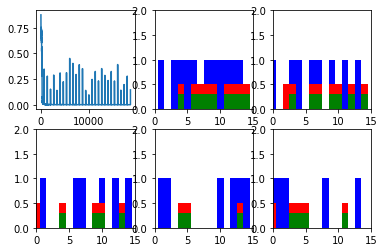

Step 100 Loss 0.00015387627


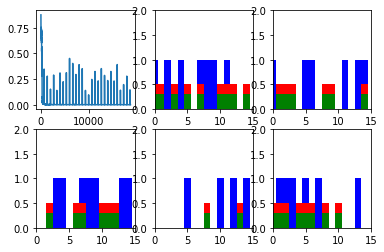

Step 200 Loss 0.00012556823


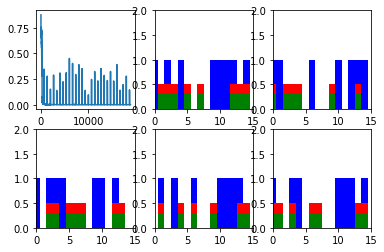

Step 300 Loss 0.00012231141


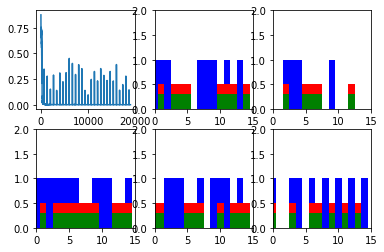

Step 400 Loss 0.00011758914


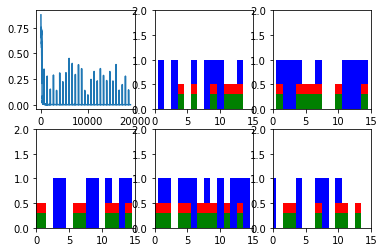

Step 500 Loss 0.000113035254


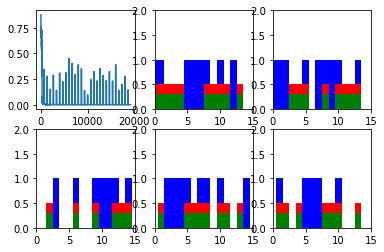

Step 600 Loss 0.000108795466


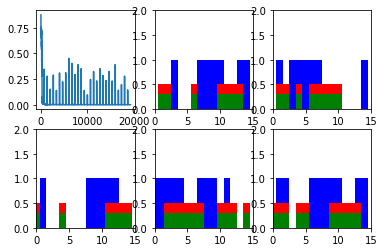

New data, epoch 29
Step 0 Loss 0.5306177


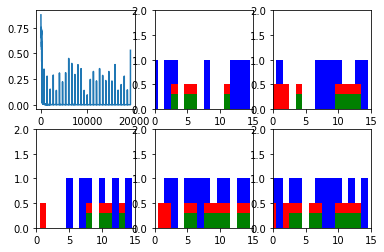

Step 100 Loss 0.00012915998


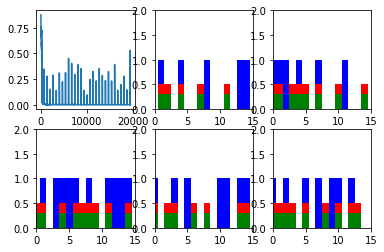

Step 200 Loss 0.00013299409


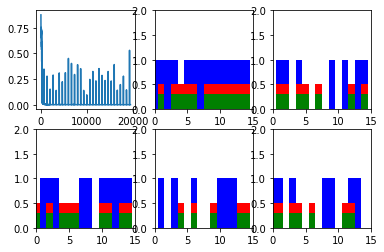

Step 300 Loss 0.000101867256


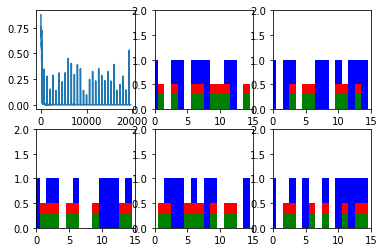

Step 400 Loss 0.00010466497


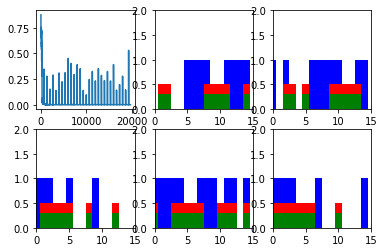

Step 500 Loss 0.00013105081


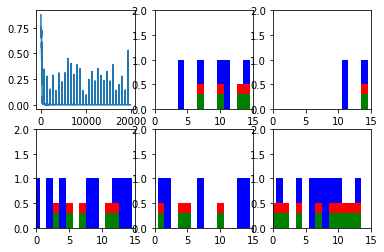

Step 600 Loss 0.00012902975


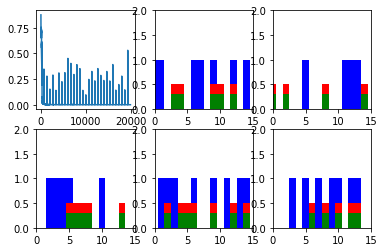

New data, epoch 30
Step 0 Loss 0.22535034


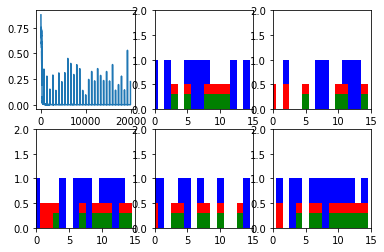

Step 100 Loss 0.000110019915


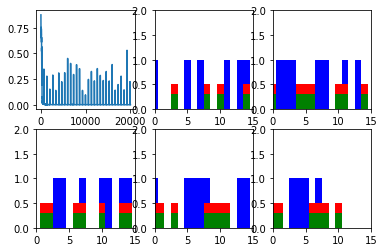

Step 200 Loss 0.00011201447


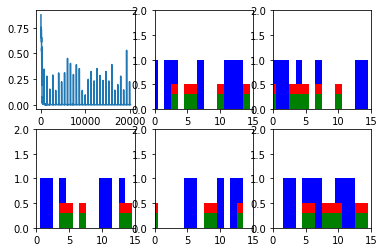

Step 300 Loss 0.00011280142


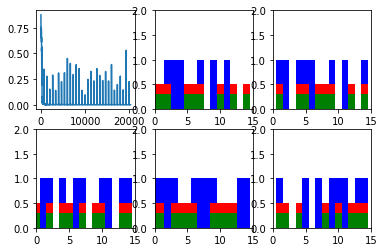

Step 400 Loss 0.000103910534


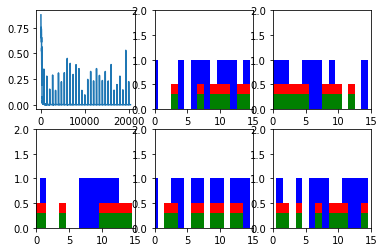

Step 500 Loss 9.4360905e-05


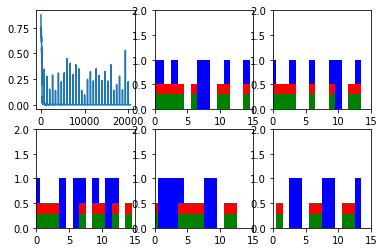

Step 600 Loss 0.00011543327


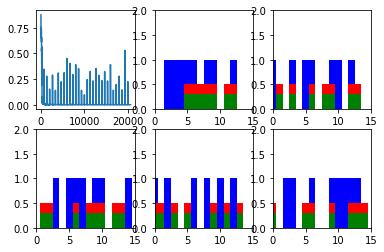

New data, epoch 31
Step 0 Loss 0.24312691


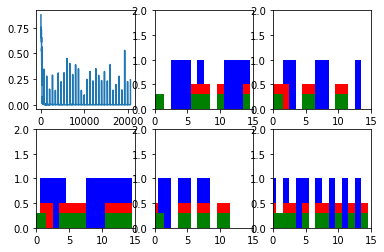

Step 100 Loss 0.00010938526


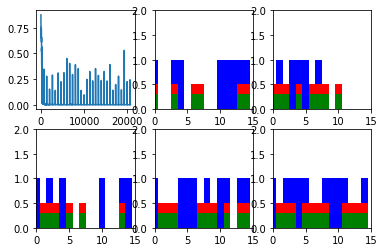

Step 200 Loss 0.00011879228


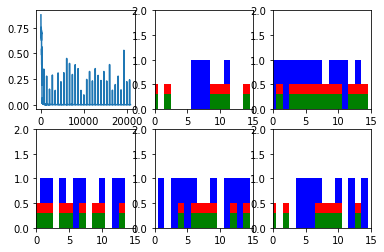

Step 300 Loss 0.00010183441


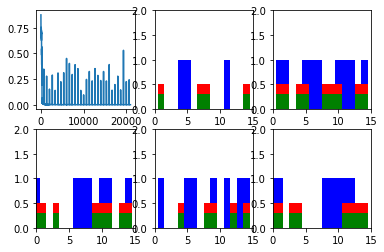

Step 400 Loss 0.00011038805


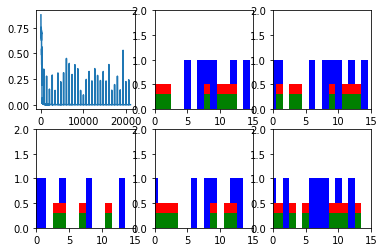

Step 500 Loss 0.00011223244


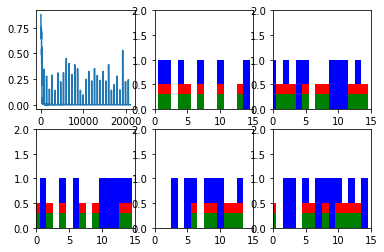

Step 600 Loss 0.00010250295


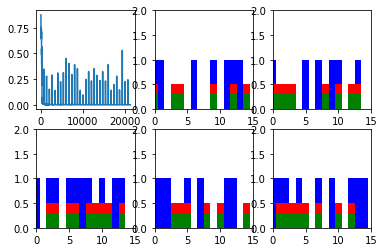

New data, epoch 32
Step 0 Loss 0.24798037


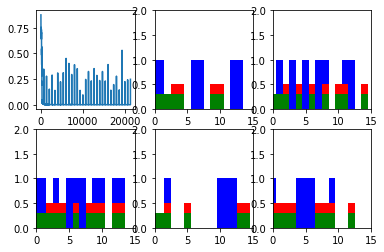

Step 100 Loss 0.000103568535


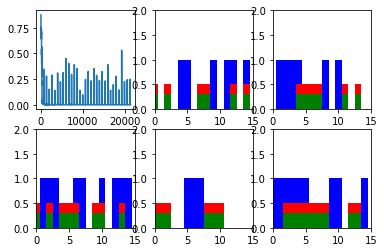

Step 200 Loss 0.000108754386


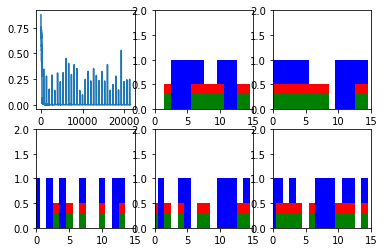

Step 300 Loss 0.000103007136


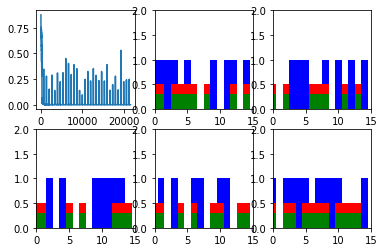

Step 400 Loss 0.000108255495


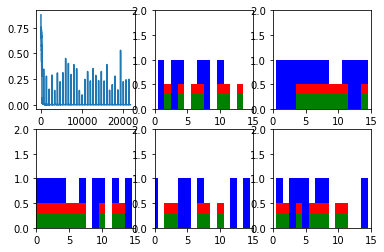

Step 500 Loss 0.000110370864


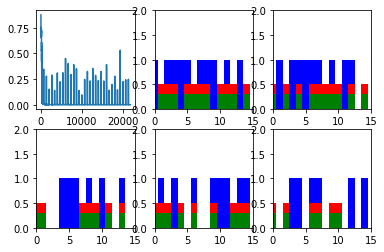

Step 600 Loss 9.806512e-05


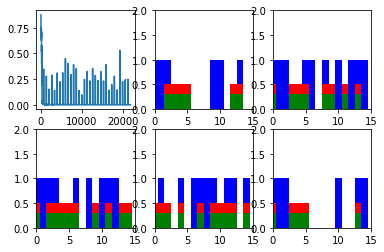

New data, epoch 33
Step 0 Loss 0.17363133


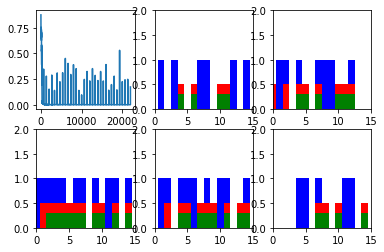

Step 100 Loss 0.00010927456


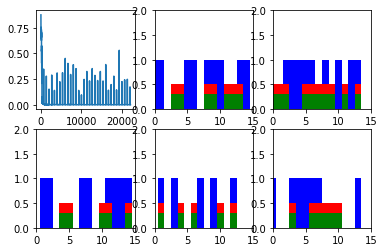

Step 200 Loss 0.00010020769


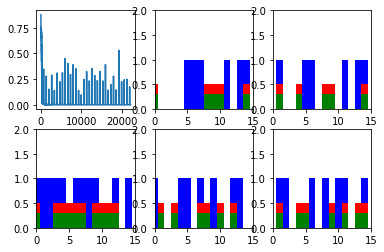

Step 300 Loss 9.353109e-05


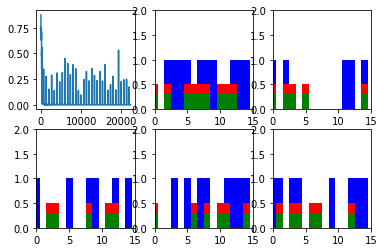

Step 400 Loss 9.3074734e-05


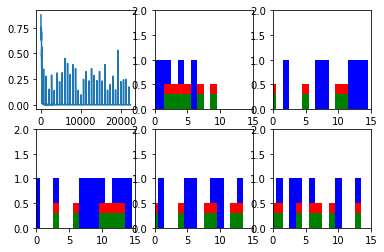

Step 500 Loss 9.433277e-05


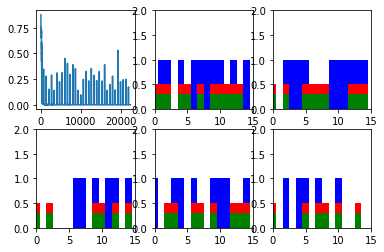

Step 600 Loss 8.6538515e-05


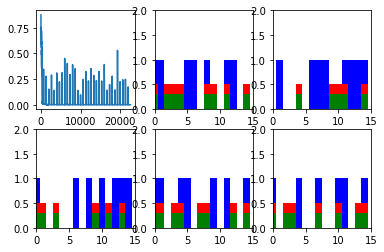

New data, epoch 34
Step 0 Loss 0.5637578


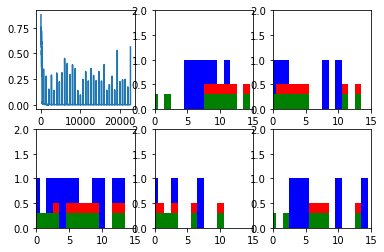

Step 100 Loss 0.00010254101


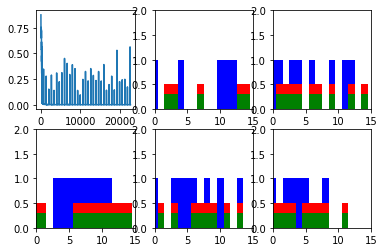

Step 200 Loss 0.00010765883


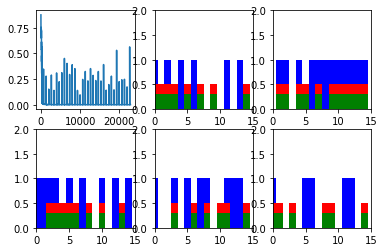

Step 300 Loss 9.1826245e-05


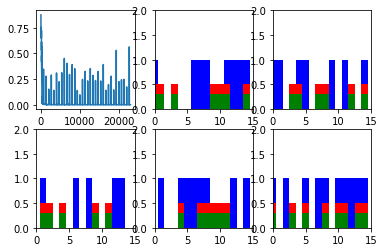

Step 400 Loss 8.6739026e-05


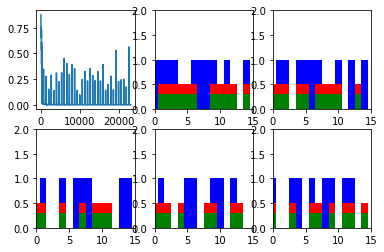

Step 500 Loss 8.530688e-05


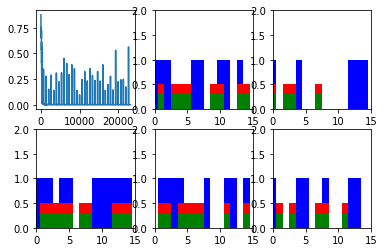

Step 600 Loss 7.927894e-05


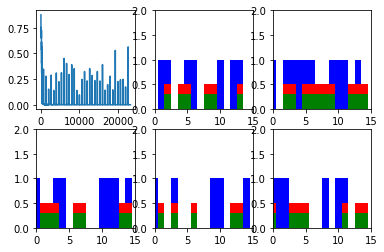

New data, epoch 35
Step 0 Loss 0.21740107


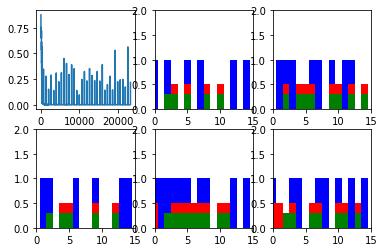

Step 100 Loss 0.00012819405


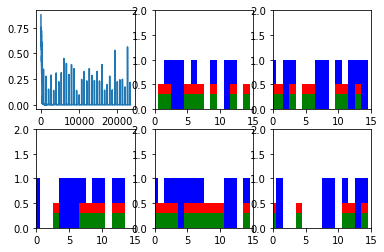

Step 200 Loss 0.0001391352


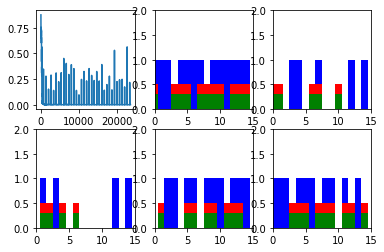

Step 300 Loss 0.00011577163


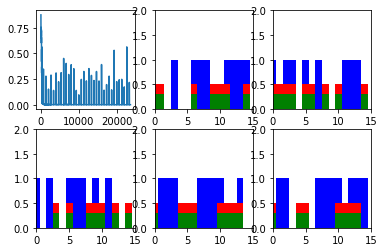

Step 400 Loss 0.00012194015


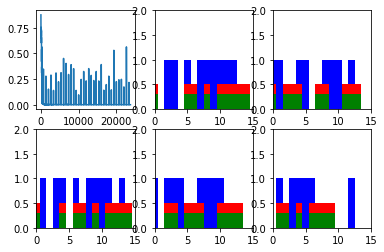

Step 500 Loss 0.0001368049


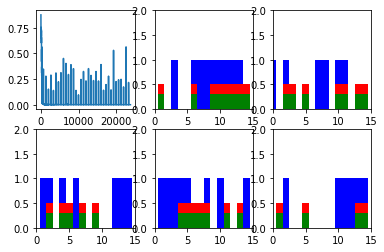

Step 600 Loss 0.000112262234


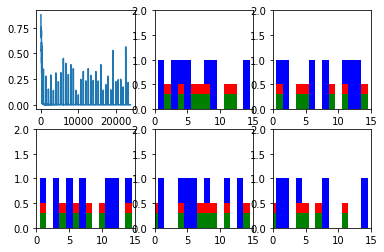

New data, epoch 36
Step 0 Loss 0.4825215


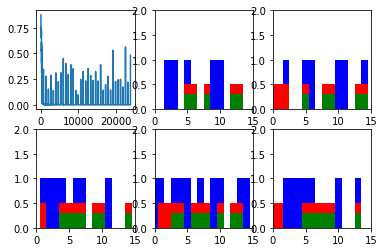

Step 100 Loss 0.00013133143


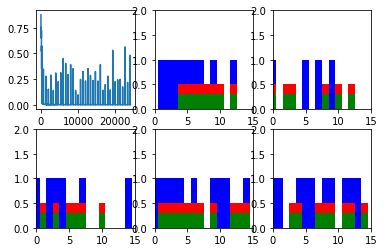

Step 200 Loss 0.00010990668


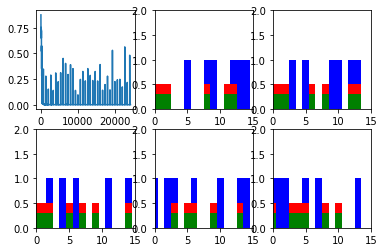

Step 300 Loss 0.00012946896


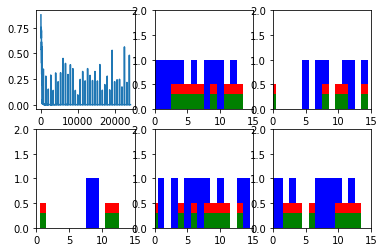

Step 400 Loss 0.000106827145


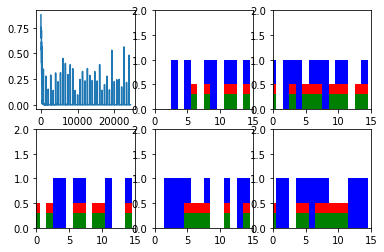

Step 500 Loss 0.0001161354


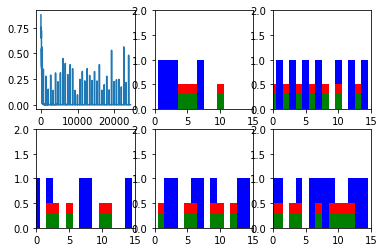

Step 600 Loss 8.194166e-05


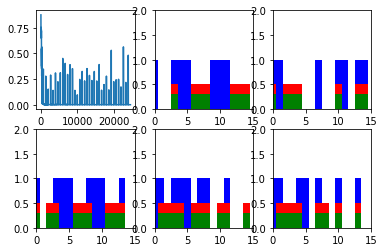

New data, epoch 37
Step 0 Loss 0.15689595


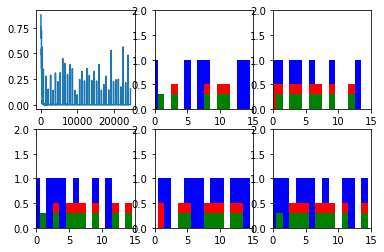

Step 100 Loss 0.00012050764


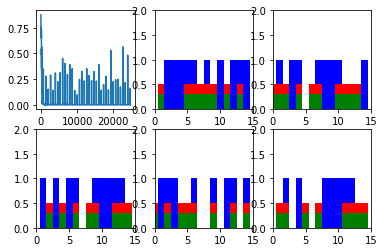

Step 200 Loss 0.00011091774


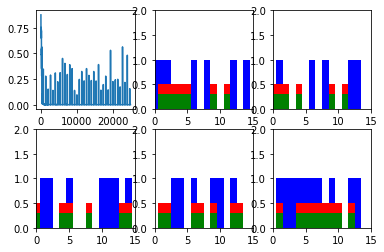

Step 300 Loss 9.342154e-05


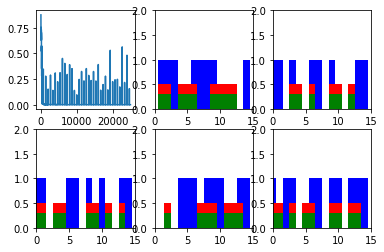

Step 400 Loss 0.000118034484


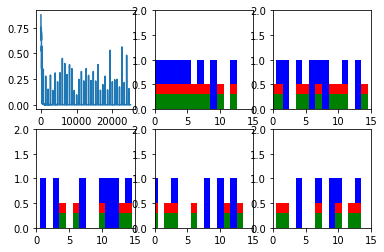

Step 500 Loss 0.00010759398


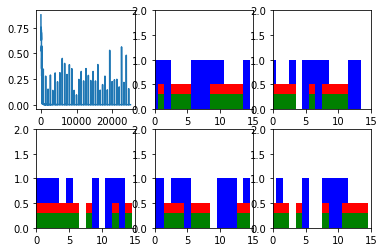

Step 600 Loss 8.758323e-05


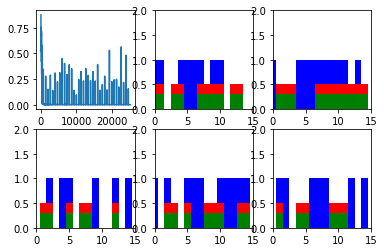

New data, epoch 38
Step 0 Loss 0.21918717


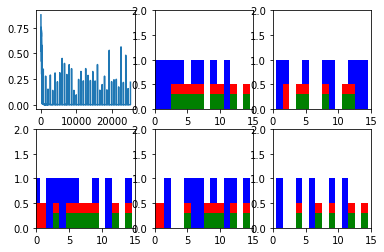

Step 100 Loss 0.000110395056


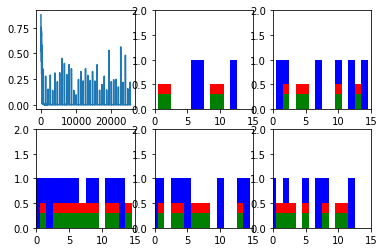

Step 200 Loss 8.652333e-05


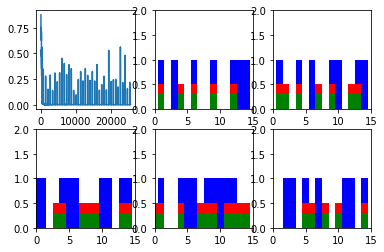

Step 300 Loss 0.000104959


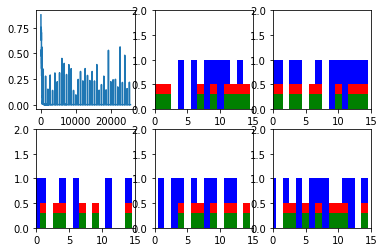

Step 400 Loss 0.000100168465


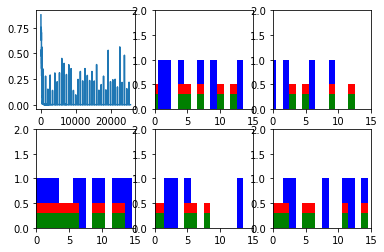

Step 500 Loss 9.628329e-05


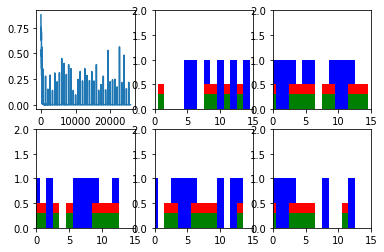

Step 600 Loss 9.425846e-05


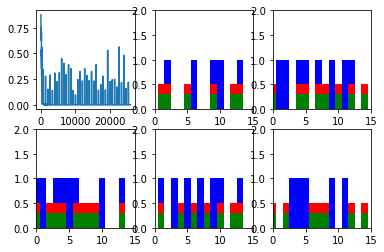

New data, epoch 39
Step 0 Loss 0.345177


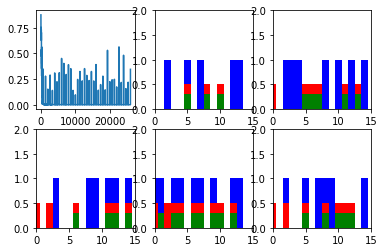

Step 100 Loss 0.00010661628


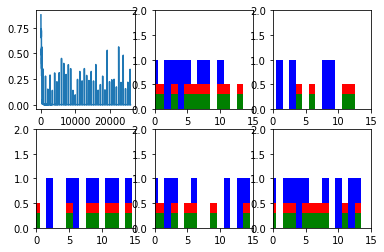

Step 200 Loss 9.588594e-05


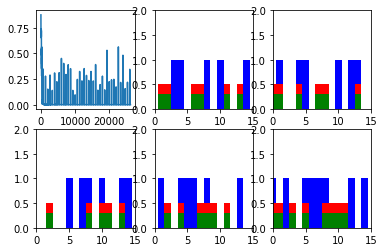

Step 300 Loss 9.293954e-05


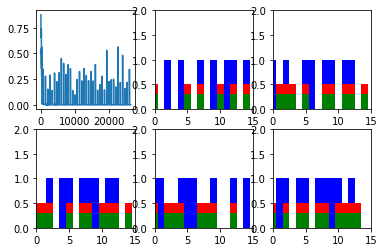

Step 400 Loss 9.744549e-05


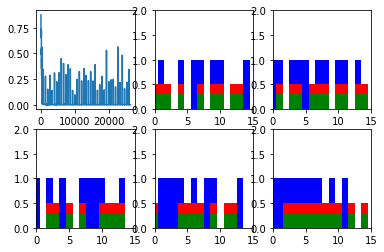

Step 500 Loss 0.00010505752


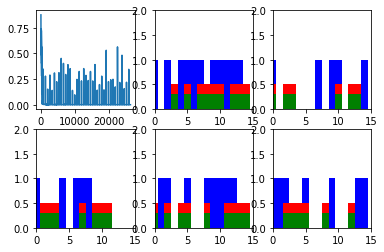

Step 600 Loss 7.550977e-05


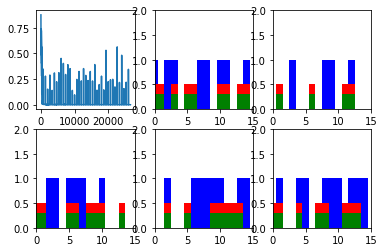

New data, epoch 40
Step 0 Loss 0.14152583


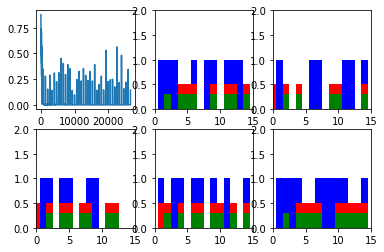

Step 100 Loss 9.108298e-05


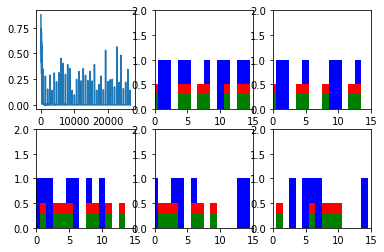

Step 200 Loss 9.45654e-05


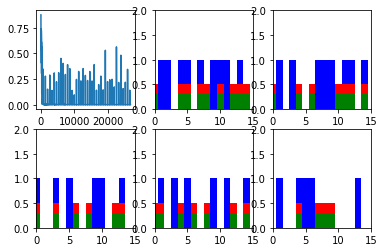

Step 300 Loss 0.00010287932


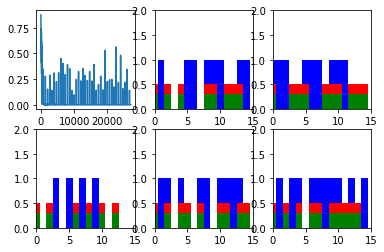

Step 400 Loss 0.00010221625


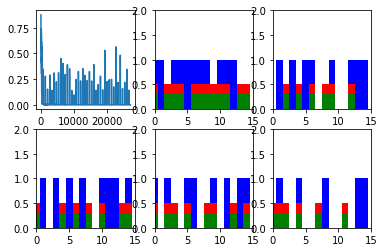

Step 500 Loss 9.899311e-05


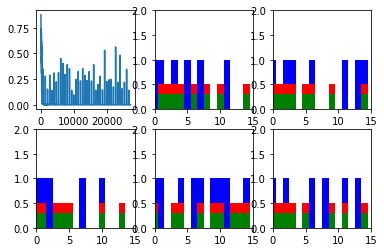

Step 600 Loss 0.00010406489


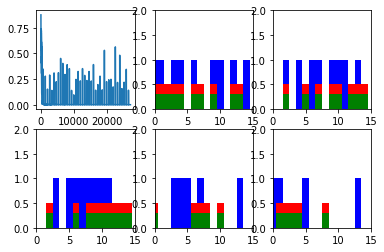

New data, epoch 41
Step 0 Loss 0.43732443


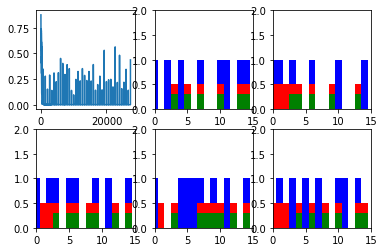

Step 100 Loss 0.00011195829


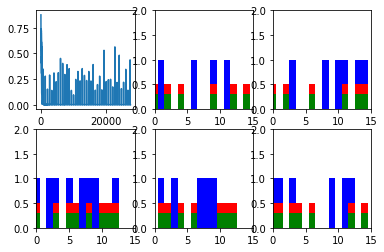

Step 200 Loss 9.243655e-05


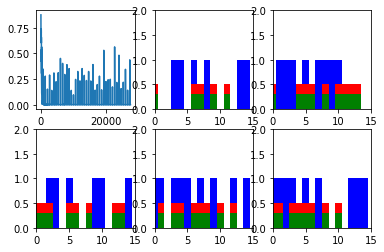

Step 300 Loss 8.110776e-05


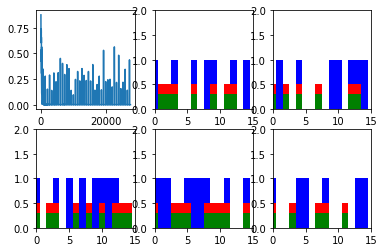

Step 400 Loss 9.2833616e-05


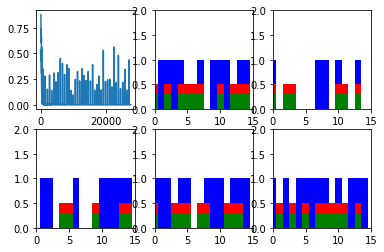

Step 500 Loss 8.119852e-05


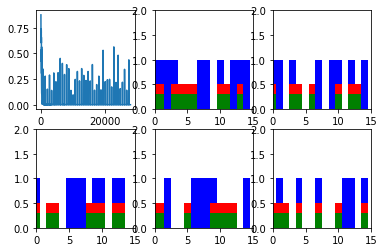

Step 600 Loss 9.307859e-05


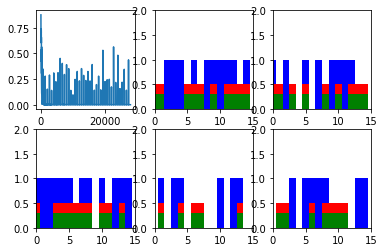

New data, epoch 42
Step 0 Loss 0.25036713


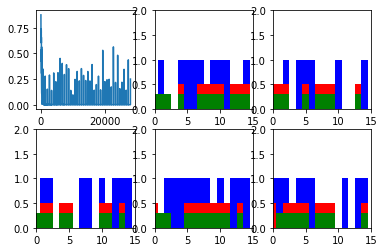

Step 100 Loss 7.312147e-05


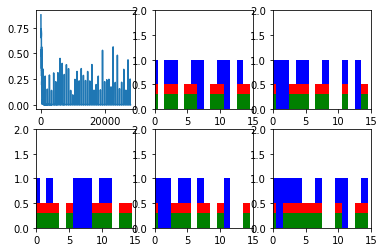

Step 200 Loss 9.054842e-05


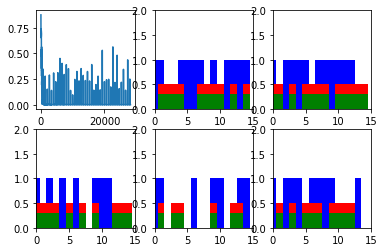

Step 300 Loss 9.4774354e-05


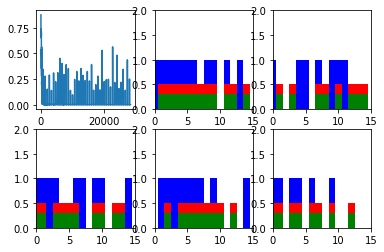

Step 400 Loss 8.2398576e-05


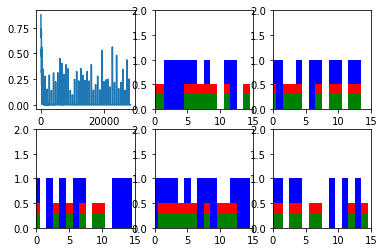

Step 500 Loss 7.7920915e-05


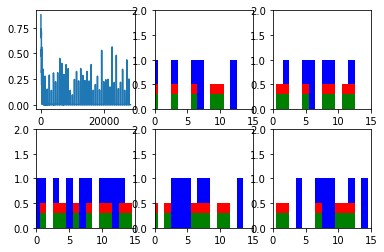

Step 600 Loss 8.155622e-05


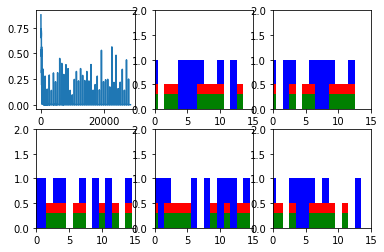

New data, epoch 43
Step 0 Loss 0.21559028


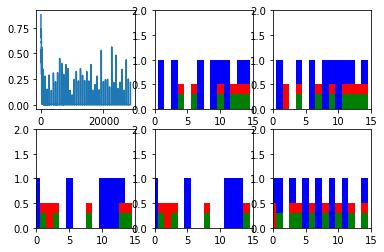

Step 100 Loss 9.994109e-05


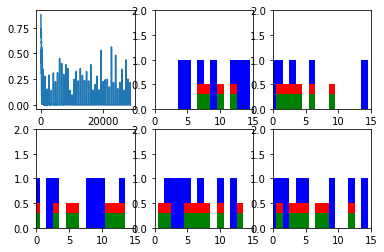

Step 200 Loss 9.858029e-05


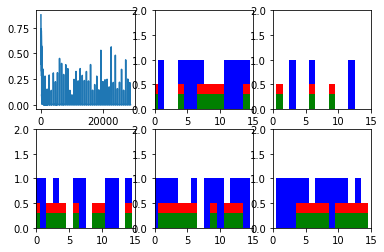

Step 300 Loss 9.469453e-05


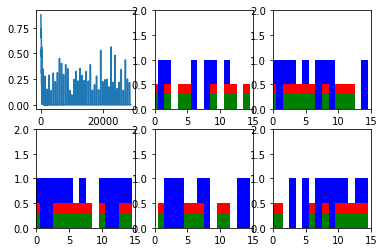

Step 400 Loss 8.8818866e-05


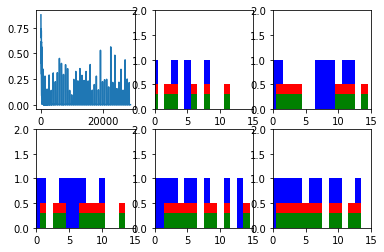

Step 500 Loss 8.5276006e-05


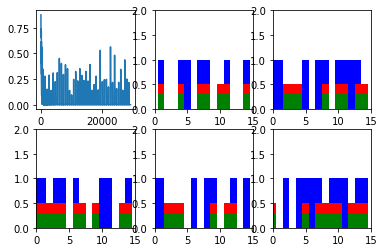

Step 600 Loss 8.3842846e-05


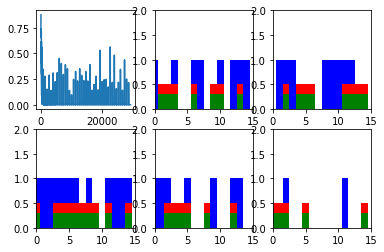

New data, epoch 44
Step 0 Loss 0.3857597


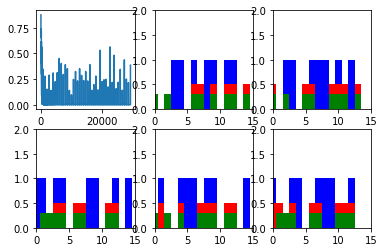

Step 100 Loss 9.5543684e-05


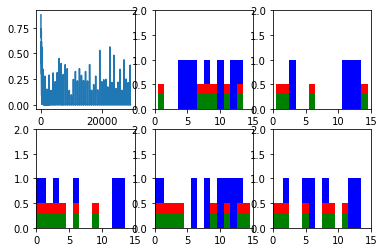

Step 200 Loss 8.651758e-05


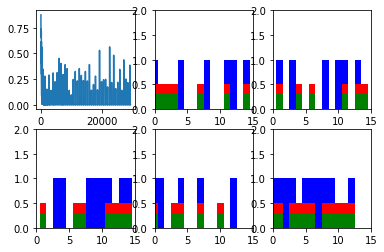

Step 300 Loss 9.0556154e-05


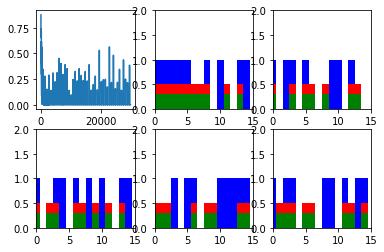

Step 400 Loss 8.9271954e-05


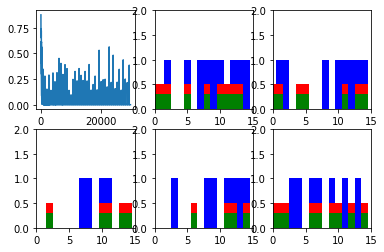

Step 500 Loss 9.188042e-05


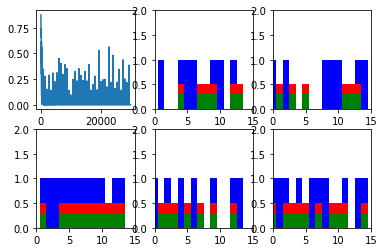

Step 600 Loss 8.6958076e-05


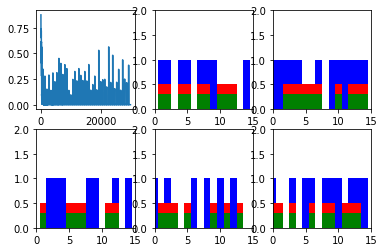

New data, epoch 45
Step 0 Loss 0.36781025


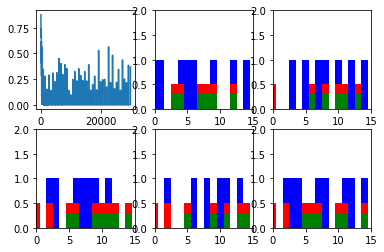

Step 100 Loss 8.1726124e-05


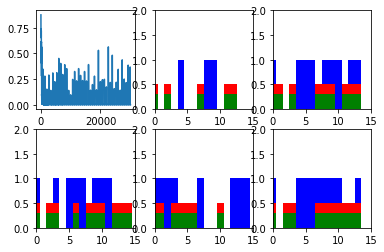

Step 200 Loss 9.056585e-05


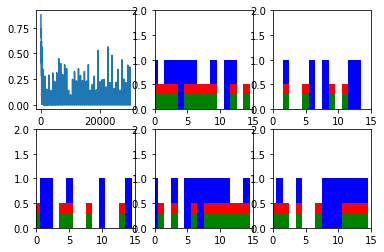

Step 300 Loss 7.819639e-05


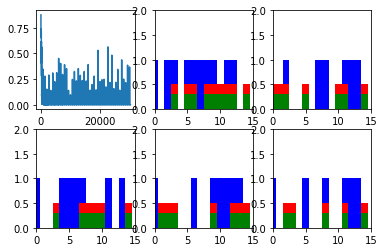

Step 400 Loss 7.9011756e-05


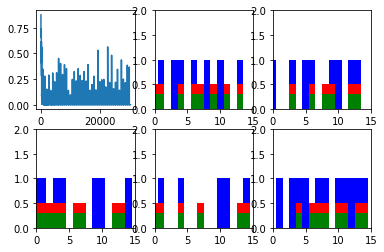

Step 500 Loss 8.08935e-05


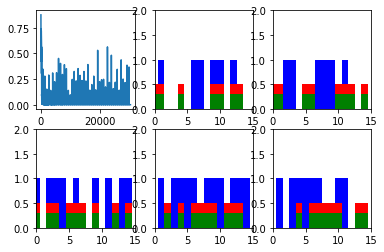

Step 600 Loss 7.777049e-05


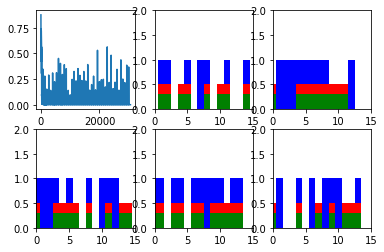

New data, epoch 46
Step 0 Loss 0.19023366


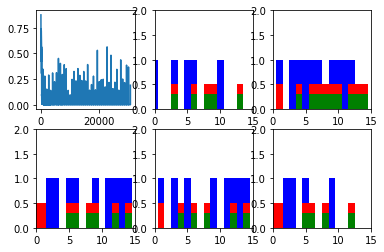

Step 100 Loss 7.779884e-05


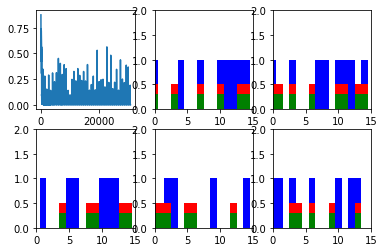

Step 200 Loss 8.331887e-05


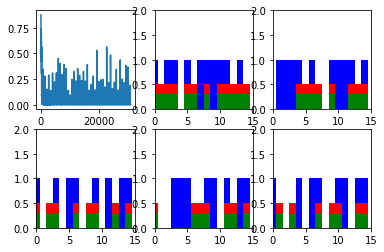

Step 300 Loss 8.165463e-05


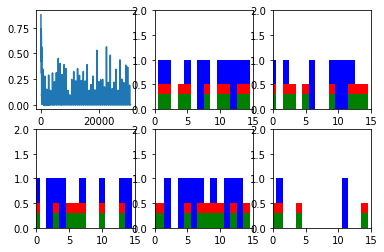

Step 400 Loss 9.6007665e-05


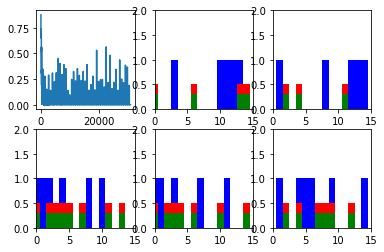

Step 500 Loss 8.658485e-05


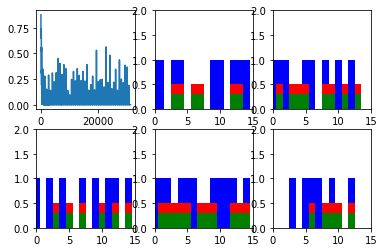

Step 600 Loss 8.0314625e-05


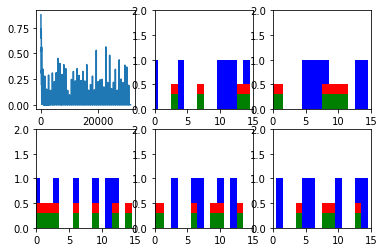

New data, epoch 47
Step 0 Loss 0.27886897


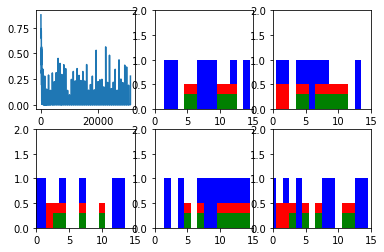

Step 100 Loss 8.5593696e-05


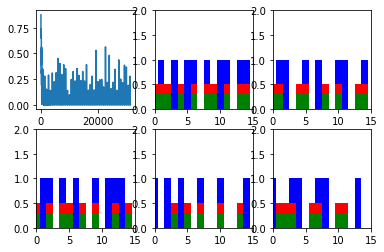

Step 200 Loss 7.475487e-05


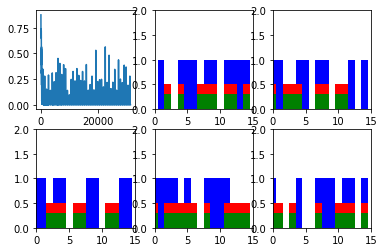

Step 300 Loss 7.818786e-05


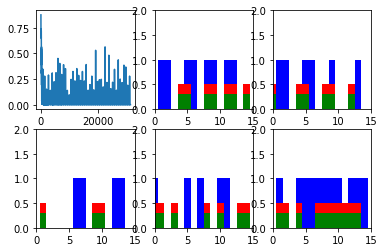

Step 400 Loss 8.605984e-05


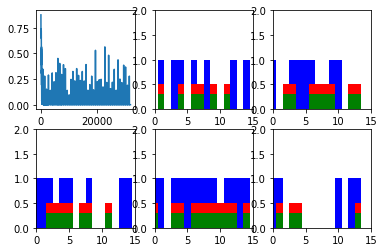

Step 500 Loss 9.393778e-05


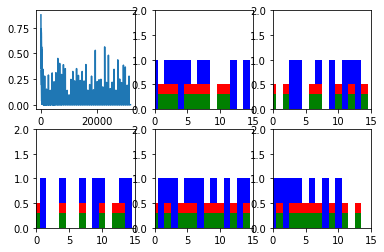

Step 600 Loss 8.626662e-05


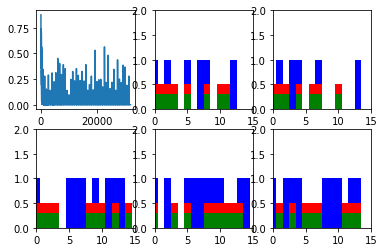

New data, epoch 48
Step 0 Loss 0.24991594


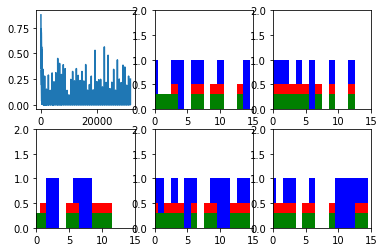

Step 100 Loss 7.939152e-05


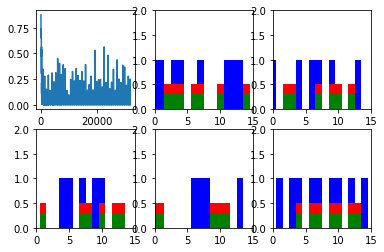

Step 200 Loss 8.508567e-05


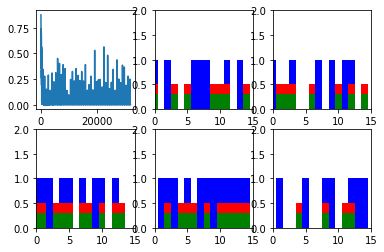

Step 300 Loss 8.9219815e-05


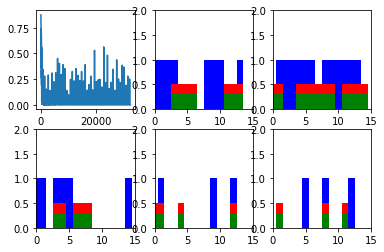

Step 400 Loss 8.467279e-05


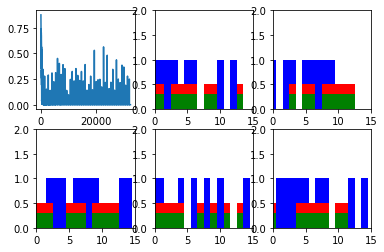

Step 500 Loss 8.549143e-05


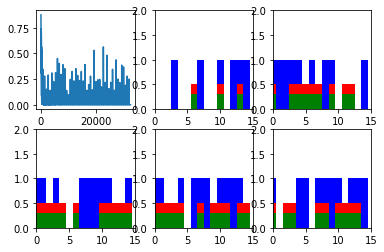

Step 600 Loss 7.731773e-05


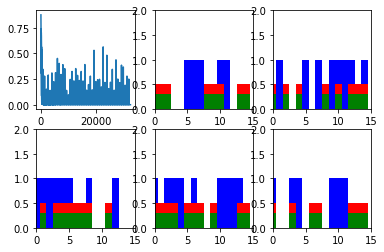

New data, epoch 49
Step 0 Loss 0.26774848


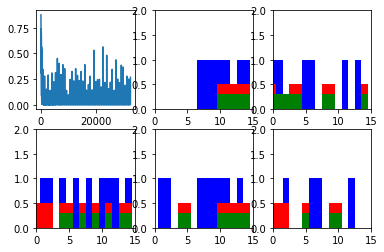

Step 100 Loss 8.065324e-05


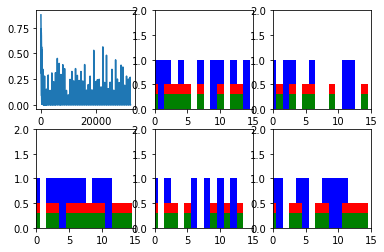

Step 200 Loss 7.997796e-05


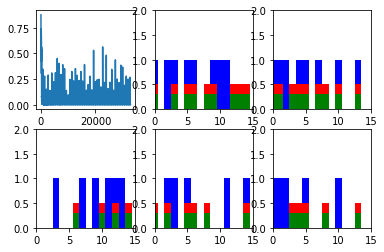

Step 300 Loss 7.177561e-05


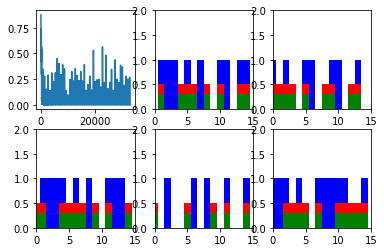

Step 400 Loss 8.7431574e-05


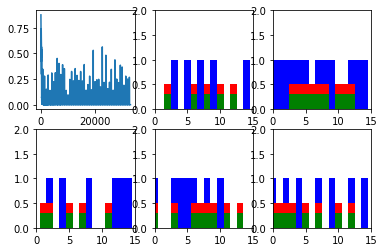

Step 500 Loss 7.572831e-05


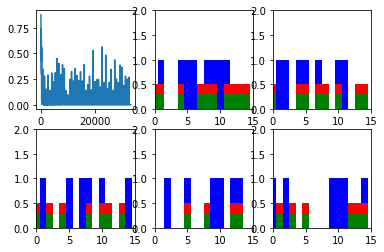

Step 600 Loss 7.9130936e-05


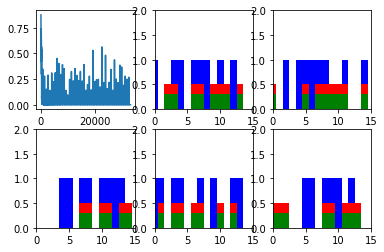

New data, epoch 50
Step 0 Loss 0.27192888


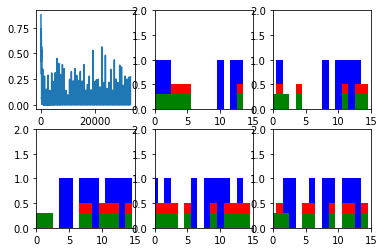

Step 100 Loss 7.701722e-05


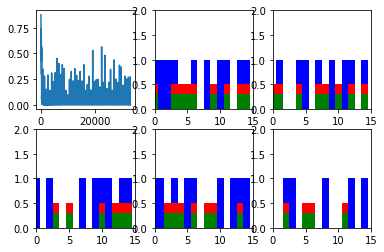

Step 200 Loss 8.197747e-05


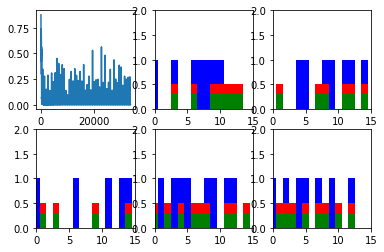

Step 300 Loss 7.946952e-05


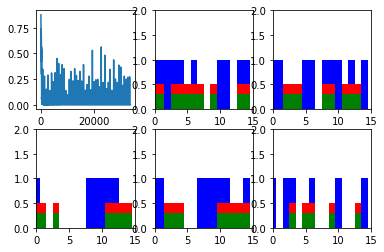

Step 400 Loss 8.1084414e-05


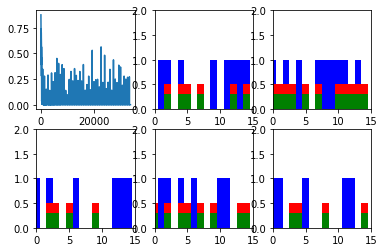

Step 500 Loss 7.540406e-05


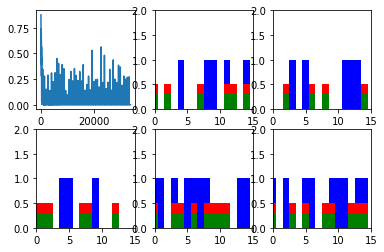

Step 600 Loss 7.634195e-05


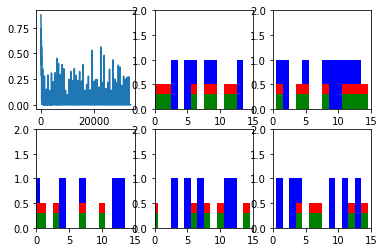

New data, epoch 51
Step 0 Loss 0.19719157


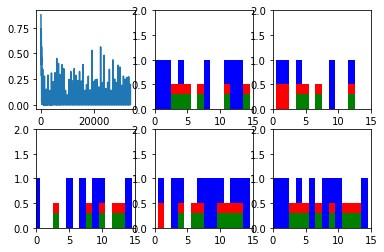

Step 100 Loss 7.52627e-05


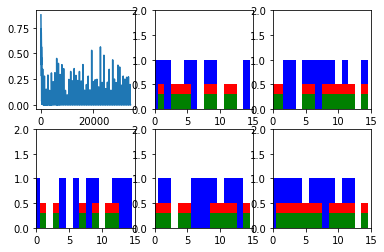

Step 200 Loss 6.3830645e-05


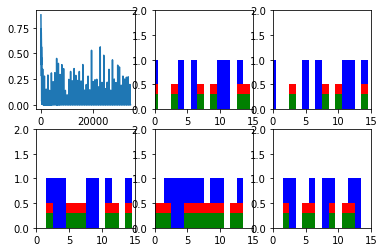

Step 300 Loss 7.753402e-05


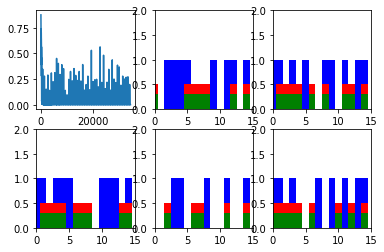

Step 400 Loss 8.7502354e-05


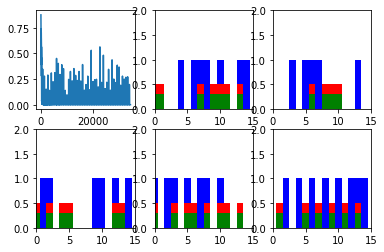

Step 500 Loss 7.127675e-05


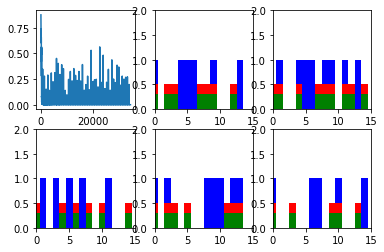

Step 600 Loss 6.274214e-05


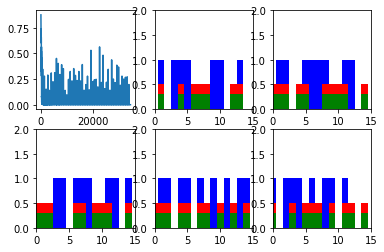

New data, epoch 52
Step 0 Loss 0.07478014


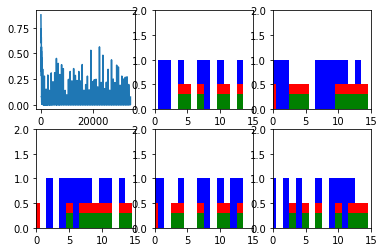

Step 100 Loss 7.4185366e-05


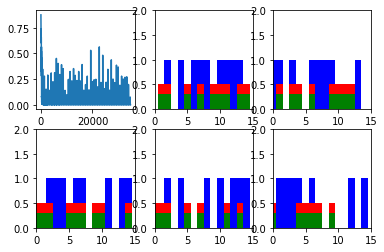

Step 200 Loss 7.0186485e-05


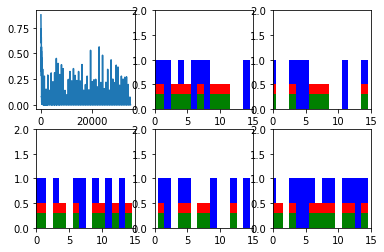

Step 300 Loss 7.058546e-05


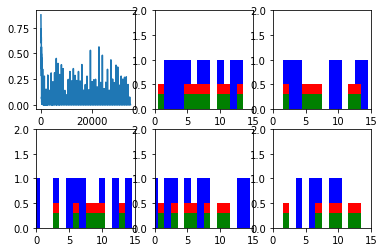

Step 400 Loss 7.048525e-05


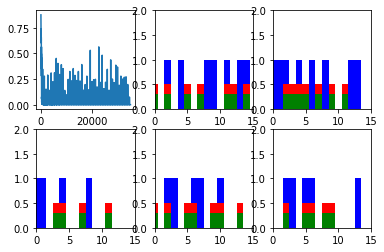

Step 500 Loss 6.931406e-05


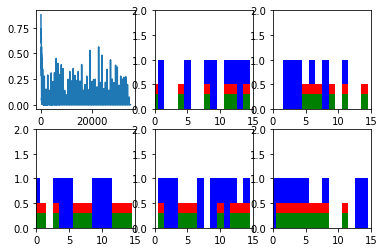

Step 600 Loss 7.357657e-05


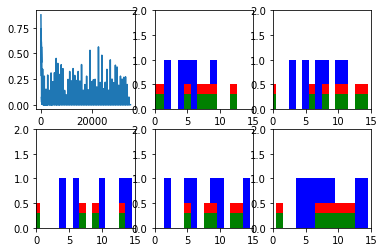

New data, epoch 53
Step 0 Loss 0.23378067


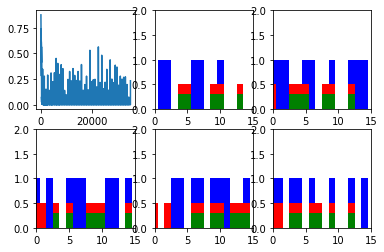

Step 100 Loss 6.3458945e-05


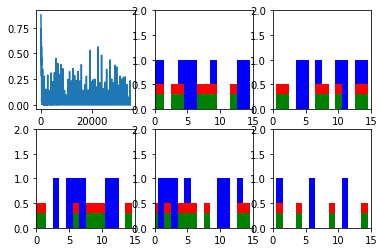

Step 200 Loss 6.1578816e-05


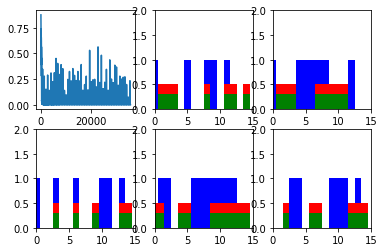

Step 300 Loss 5.776912e-05


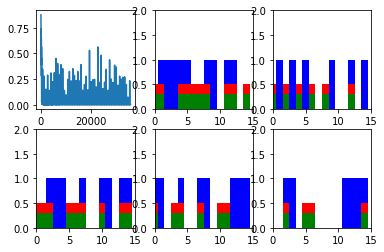

Step 400 Loss 8.3596045e-05


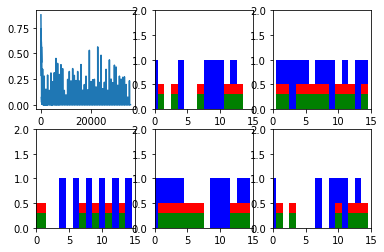

Step 500 Loss 7.241501e-05


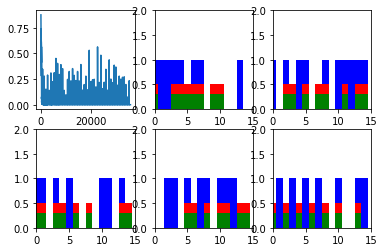

Step 600 Loss 6.1690196e-05


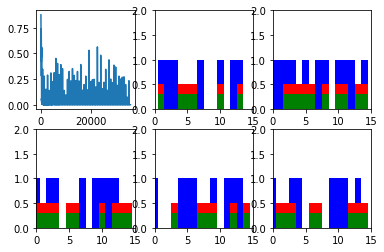

New data, epoch 54
Step 0 Loss 0.1715125


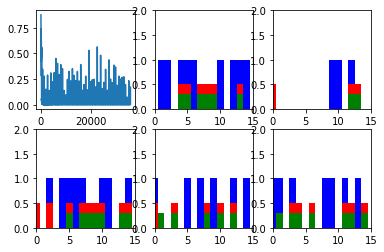

Step 100 Loss 7.286314e-05


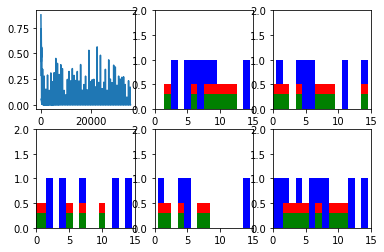

Step 200 Loss 8.104828e-05


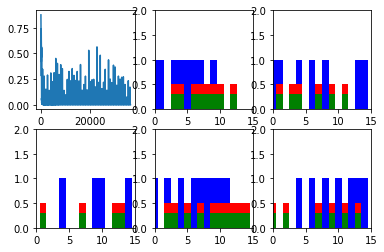

Step 300 Loss 6.182522e-05


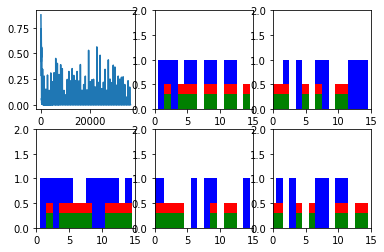

Step 400 Loss 7.190799e-05


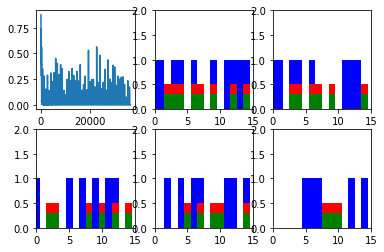

Step 500 Loss 6.7272034e-05


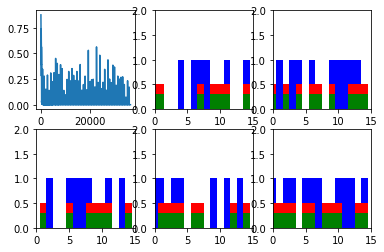

Step 600 Loss 6.717495e-05


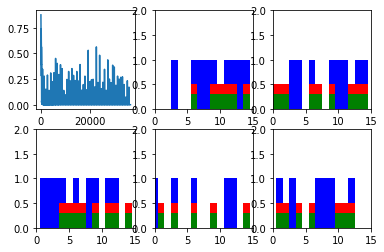

New data, epoch 55
Step 0 Loss 0.33844164


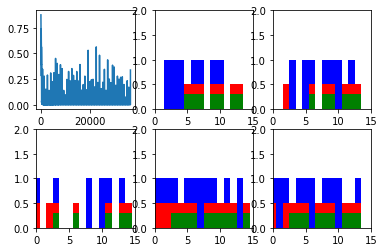

Step 100 Loss 0.00016495655


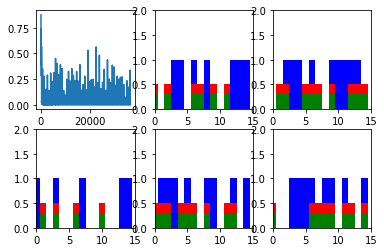

Step 200 Loss 0.00014064007


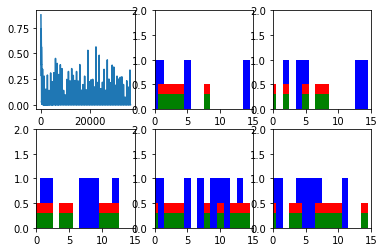

Step 300 Loss 0.00011266931


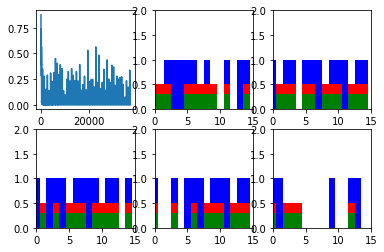

Step 400 Loss 0.000114360424


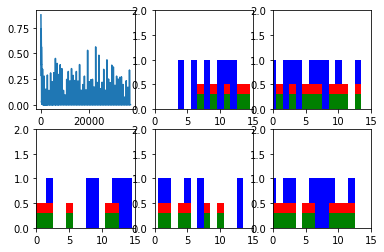

Step 500 Loss 0.00011172429


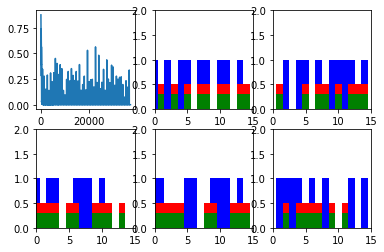

Step 600 Loss 0.00011147082


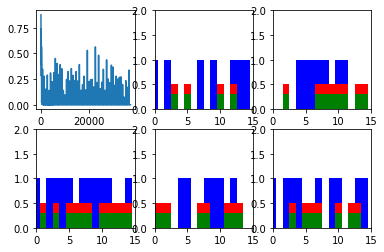

New data, epoch 56
Step 0 Loss 0.44860193


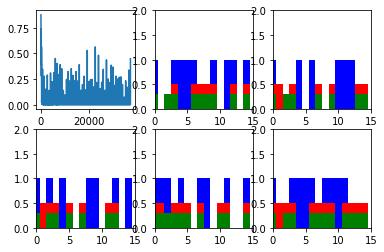

Step 100 Loss 0.00011650992


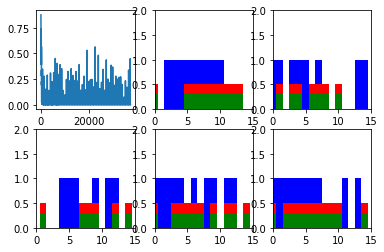

Step 200 Loss 0.000112780755


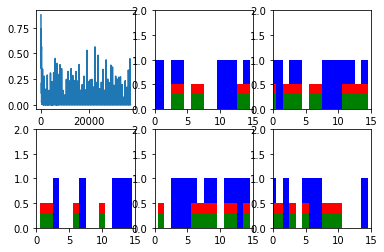

Step 300 Loss 0.000119868826


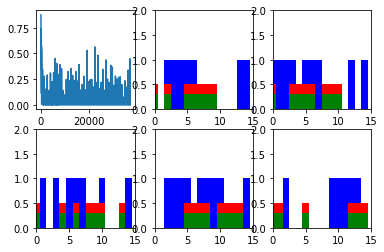

Step 400 Loss 0.000115537805


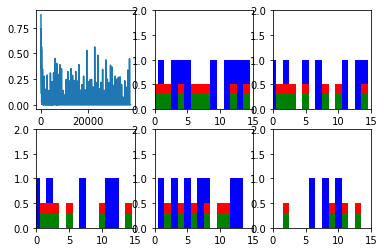

Step 500 Loss 9.963568e-05


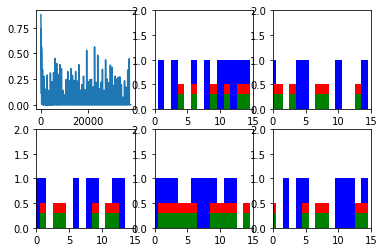

Step 600 Loss 0.0001089027


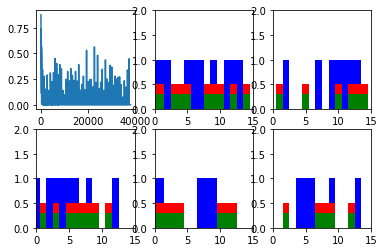

New data, epoch 57
Step 0 Loss 0.34332713


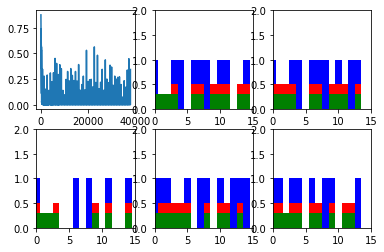

Step 100 Loss 0.000114672606


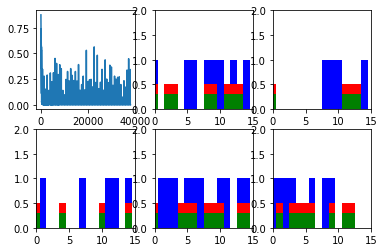

Step 200 Loss 9.149061e-05


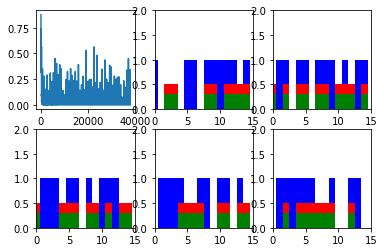

Step 300 Loss 0.0001002209


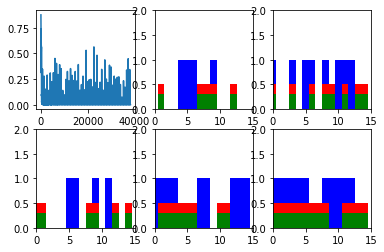

Step 400 Loss 9.540361e-05


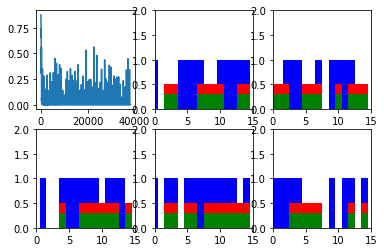

Step 500 Loss 8.5392996e-05


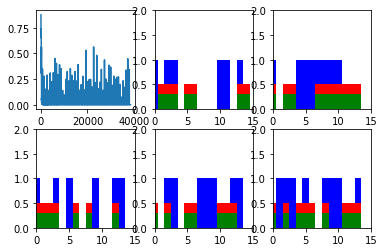

Step 600 Loss 9.335378e-05


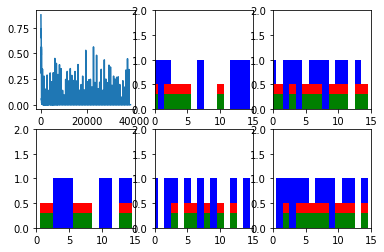

New data, epoch 58
Step 0 Loss 0.26943418


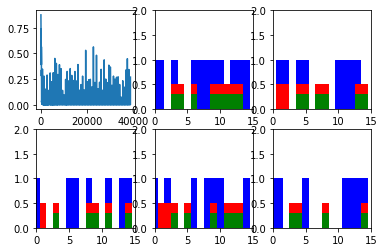

Step 100 Loss 9.622586e-05


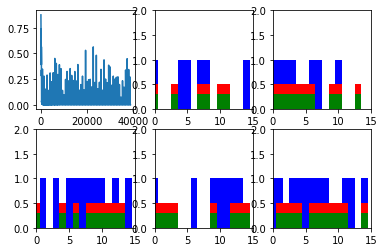

Step 200 Loss 9.0805064e-05


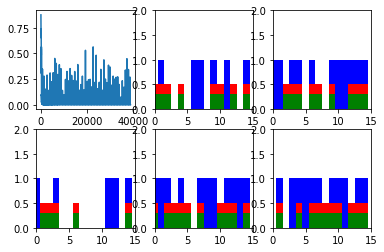

Step 300 Loss 8.6729735e-05


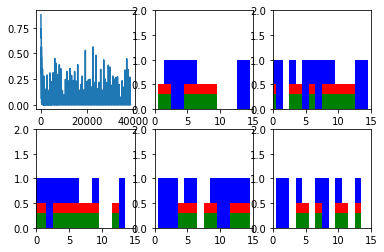

Step 400 Loss 8.316521e-05


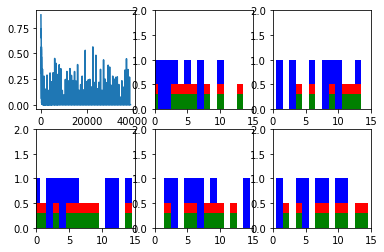

Step 500 Loss 9.912034e-05


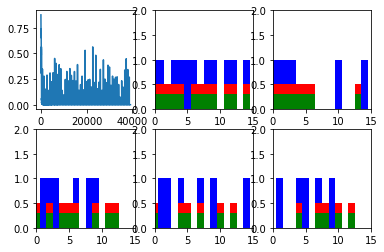

Step 600 Loss 8.297826e-05


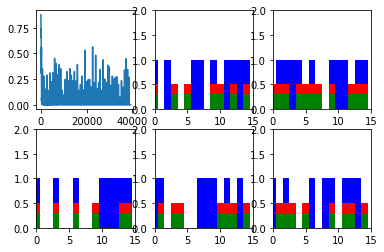

New data, epoch 59
Step 0 Loss 0.13780318


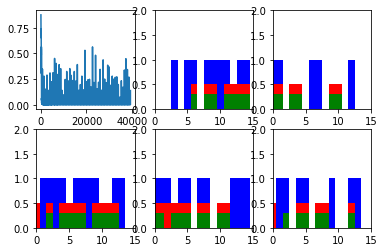

Step 100 Loss 8.069116e-05


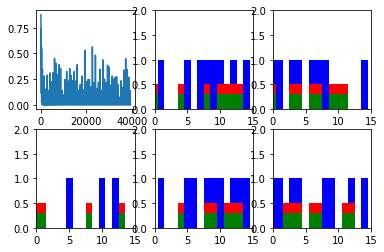

Step 200 Loss 8.118254e-05


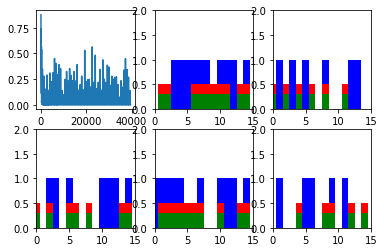

Step 300 Loss 7.154025e-05


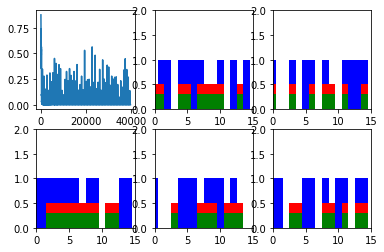

Step 400 Loss 8.252219e-05


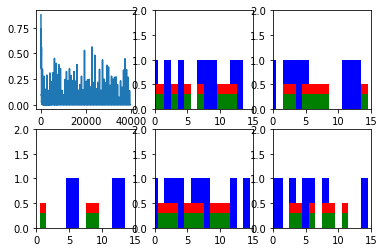

Step 500 Loss 6.886735e-05


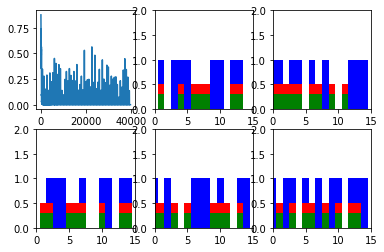

Step 600 Loss 7.61333e-05


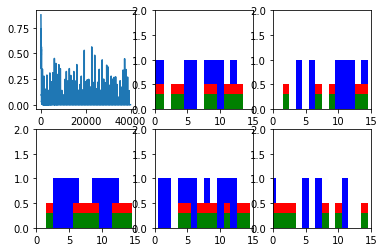

New data, epoch 60
Step 0 Loss 0.17987992


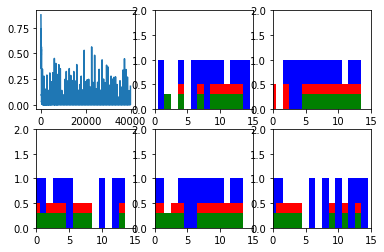

Step 100 Loss 8.180866e-05


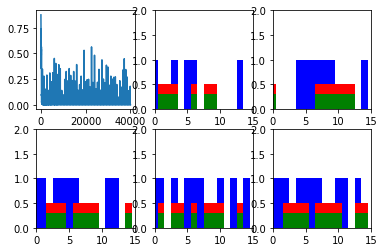

Step 200 Loss 7.857617e-05


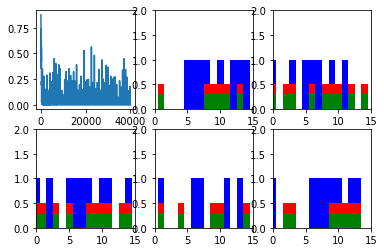

Step 300 Loss 6.687093e-05


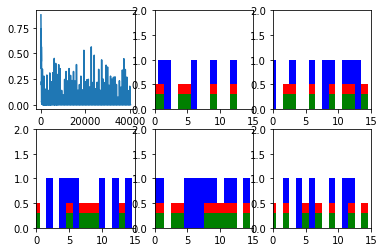

Step 400 Loss 7.186602e-05


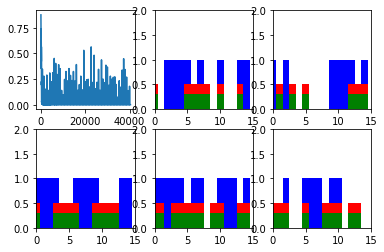

Step 500 Loss 8.226806e-05


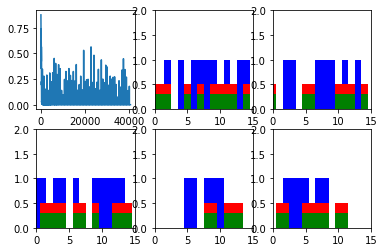

Step 600 Loss 7.872727e-05


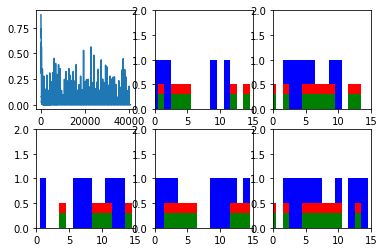

New data, epoch 61
Step 0 Loss 0.15774392


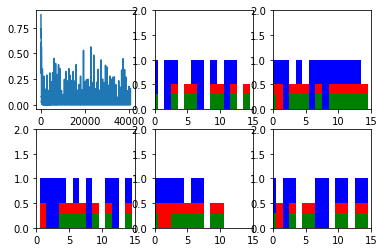

Step 100 Loss 6.828425e-05


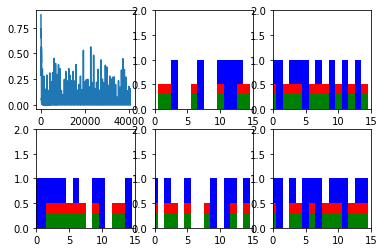

Step 200 Loss 8.03232e-05


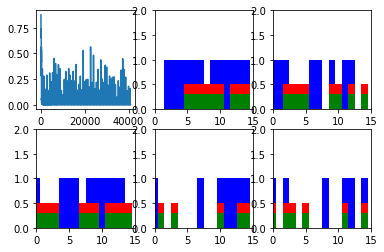

Step 300 Loss 7.55871e-05


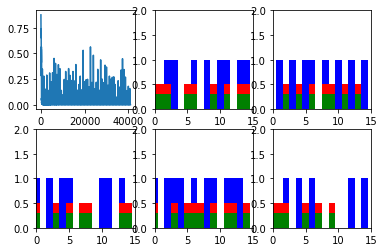

Step 400 Loss 8.1470826e-05


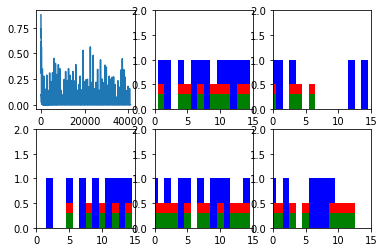

Step 500 Loss 7.541532e-05


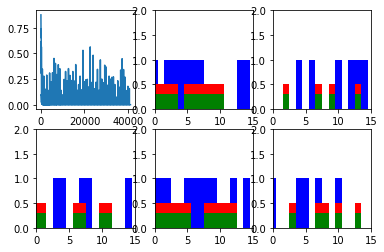

Step 600 Loss 7.8331715e-05


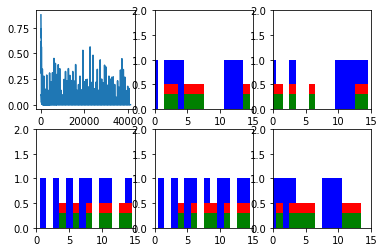

New data, epoch 62
Step 0 Loss 0.17921998


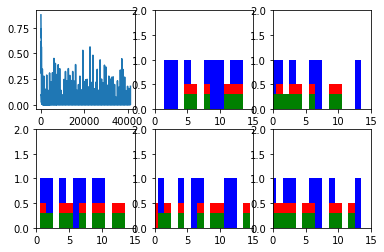

Step 100 Loss 6.769134e-05


In [ ]:
#Step 3 Training the network
with tf.Session() as sess:
    #we stupidly have to do this everytime, it should just know
    #that we initialized these vars. v2 guys, v2..
    sess.run(tf.initialize_all_variables())
    #interactive mode
    plt.ion()
    #initialize the figure
    plt.figure()
    #show the graph
    plt.show()
    #to show the loss decrease
    loss_list = []

    for epoch_idx in range(num_epochs):
        #generate data at eveery epoch, batches run in epochs
        x,y = generateData()
        #initialize an empty hidden state
        _current_state = np.zeros((batch_size, state_size))

        print("New data, epoch", epoch_idx)
        #each batch
        for batch_idx in range(num_batches):
            #starting and ending point per batch
            #since weights reoccuer at every layer through time
            #These layers will not be unrolled to the beginning of time, 
            #that would be too computationally expensive, and are therefore truncated 
            #at a limited number of time-steps
            start_idx = batch_idx * truncated_backprop_length
            end_idx = start_idx + truncated_backprop_length

            batchX = x[:,start_idx:end_idx]
            batchY = y[:,start_idx:end_idx]
            
            #run the computation graph, give it the values
            #we calculated earlier
            _total_loss, _train_step, _current_state, _predictions_series = sess.run(
                [total_loss, train_step, current_state, predictions_series],
                feed_dict={
                    batchX_placeholder:batchX,
                    batchY_placeholder:batchY,
                    init_state:_current_state
                })

            loss_list.append(_total_loss)

            if batch_idx%100 == 0:
                print("Step",batch_idx, "Loss", _total_loss)
                plot(loss_list, _predictions_series, batchX, batchY)

plt.ioff()
plt.show()

You can see that we are moving truncated_backprop_length steps forward on each iteration (line 15–19), but it is possible have different strides. This subject is further elaborated in this article. The downside with doing this is that truncated_backprop_length need to be significantly larger than the time dependencies (three steps in our case) in order to encapsulate the relevant training data. Otherwise there might a lot of “misses”, as you can see on the figure below.

In [ ]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*uKuUKp_m55zAPCzaIemucA.png")

Time series of squares, the elevated black square symbolizes an echo-output, which is activated three steps from the echo input (black square). The sliding batch window is also striding three steps at each run, which in our sample case means that no batch will encapsulate the dependency, so it can not train.

The network will be able to exactly learn the echo behavior so there is no need for testing data.
The program will update the plot as training progresses, Blue bars denote a training input signal (binary one), red bars show echos in the training output and green bars are the echos the net is generating. The different bar plots show different sample series in the current batch. Fully trained at 100 epochs look like this

In [ ]:
Image(url= "https://cdn-images-1.medium.com/max/1600/1*ytquMdmGMJo0-3kxMCi1Gg.png")